In [40]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.optimize import linear_sum_assignment
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from bayes_opt import BayesianOptimization


import torch
import torch.nn as nn
from torch_geometric.data import DataLoader, Batch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import Set2Set
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import math
import numpy as np
from boruta import BorutaPy
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


### This notebook is dedicated to the best offensive rebounding guard I have ever seen. The king of long rebounds. This notebook will be UConn themed wherever possible.


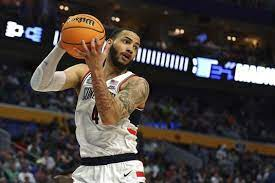

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Predicting Offensive Rebounds in Basketball: A Location-Based Approach**

Basketball is a fast-paced sport, rich in strategies and opportunities for data analysis. One critical moment that can shift the momentum of a game is the rebound after a missed shot. The ability to anticipate and secure an offensive rebound can create additional opportunities to score, making it a valuable skill on the court. The challenge presented here is to leverage the on-court location data of players to predict the probability of a team securing an offensive rebound after a shot miss.

## **Dataset Overview**

The datasets provided for this challenge come in two flavors:

1. *Play-by-Play Data (PBP)*: This dataset captures play-level details. Crucially, it records the team names, and for the training set, whether a rebound is offensive or defensive.

2. *Location Data (Locs)*: This is the centerpiece of the challenge. For each play, it records the on-court coordinates of each player *at the moment a shot is taken*. This dataset differentiates between the shooter, the offensive players, and the defensive players.

A critical note is that all the shots considered in both the training and test sets are misses, which are then rebounded either offensively or defensively.

## **Objective**

Given this data, the task is to predict the likelihood of an offensive rebound post a missed shot. The prediction will be based on the positions of the players at the time of the shot.

## **My Approach**

In my exploration of this problem, I have undertaken a comprehensive approach to feature engineering and model testing:

1. <u>Distance Features</u>:           Calculated distances between key players and positions to gauge the immediate opportunity or challenge in securing a rebound.

2. <u>Angle Features</u>:              Considered angles to understand players' relative positions to the basket.

3. <u>Box-Out Responsibility</u>:      Paired players based on potential matchups, considering 'boxing out' in rebound scenarios.

4. <u>Segmented Models by Shot Distance Zones</u>: Recognizing that shot trajectories and subsequent rebound positions can vary based on the shot's origin, I developed models specific to different shot zones.

5. <u>Model Exploration</u>:           Beyond traditional algorithms, I experimented with Graph Neural Networks (GNNs) and Convolutional Neural Networks (CNNs) to capture the spatial relationships between players.

As we delve into this notebook, you will witness a step-by-step breakdown of these strategies, supported by visualizations, model evaluations, and insights. By leveraging both domain knowledge and advanced data techniques, my objective is to provide an in-depth and accurate model for predicting offensive rebounds in basketball.

Let's dive in.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Exploratory Data Analysis & Data Preprocessing**

In this section, we strive to deeply understand our dataset and derive insights that will be critical for our modeling phase. Our data revolves around basketball play-by-play events, focusing particularly on shots that are missed and subsequently rebounded.

## EDA Structure:

### 1. Univariate Analysis:
We'll start by examining the distribution of key variables, such as shot locations, the frequency of offensive vs. defensive rebounds, and the distribution of shots among different teams.

### 2. Bivariate Analysis:
We'll then delve into relationships between variables. For instance, does the location of the shooter influence the probability of an offensive rebound? How does player positioning relate to rebound outcomes?

### 3. Feature Engineering Insights:
While our main feature engineering phase comes after EDA, our initial exploration can guide us in constructing meaningful features. For instance, player distance from the basket might emerge as a potential predictor.

### 4. Missing Data and Outliers:
We'll identify any missing values and decide on imputation strategies. Similarly, outliers, if any, will be flagged, and we'll determine how to handle them.

### 5. Visual Exploration:
Throughout the EDA, we'll make extensive use of visual tools: scatter plots to understand player positioning, histograms for distributions, and heatmaps.

By the end of this section, we'll have a comprehensive understanding of our data's characteristics, potential challenges, and areas of opportunity for our predictive modeling phase.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Examining the Available Data**

In [3]:
# Loading in each dataset
train_locs = pd.read_csv('train_locs.csv')
train_pbp = pd.read_csv('train_pbp.csv')
test_locs = pd.read_csv('test_locs.csv')
test_pbp = pd.read_csv('test_pbp.csv')

In [4]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [5]:
# displaying the raw data
training_data.head(2)

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2


#### **Key notes about PBP data**
- The test set appears randomly sampled, so the training set plays do not all occur prior to the test set plays
- This eliminates team or conference offensive rebounding percentage as a potential feature because of data leakage concerns

In [ ]:
train_pbp.head(3)

,id,is_oreb,team,opponent,conference,opp_conference
0,2-2,0,Kentucky,Duke,SEC,ACC
1,2-3,0,Duke,Kentucky,ACC,SEC
2,2-4,0,Kentucky,Duke,SEC,ACC


In [ ]:
test_pbp.head(3)

,id,team,opponent,conference,opp_conference
0,2790-2,Iowa St.,Chicago St.,Big 12,WAC
1,4712-4,Vanderbilt,Auburn,SEC,SEC
2,2094-2,Oregon St.,Colorado,PAC 12,PAC 12


#### **Creating binary shooter and offense columns**
- These new columns capture the important details about each player as the number in the annotation code does not indicate position or have any significance

In [6]:
# Assign 1 if the player is on the offensive team and 0 if on the defensive team
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
# Assign 1 if the player is the shooter (based on 'annotation_code' containing 's') and 0 otherwise.
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [7]:
# Ensuring the columns are added
training_data.head(2)

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0


### **Calculating Shooter's Distance from the Basket**

#### Challenge:

Given the dynamic nature of a basketball game, players can take shots aiming at either of the two baskets. Our dataset provides the shooter's coordinates on the court at the time of the shot. However, an immediate challenge arises: determining which basket the player is targeting. This information is pivotal in accurately computing the shooter's distance from the intended basket.

#### Plan of Attack:

1. *Baskets' Coordinates*: 
    - Left Hoop: Located at `(4,25)`.
    - Right Hoop: Located at `(90,25)`.
    
    These will act as reference points for our distance calculations.

2. *Initial Hypothesis*:
    Since players predominantly aim for the basket closer to them, a simple initial approach could be to calculate the distance to both baskets and assume the player is targeting the nearer one.

3. *Team Side Information*:
    Since we have access to multiple data points per game we can take samples at the beginning and end of games to verify the direction of the shot


In [10]:
# Define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# Calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        hoop = 0
    else:
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [11]:
# keeping only rows for the shooter in each play
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']
# Hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)
# splitting id so that grouping by id is possible
shooter_data_train['game_number'] = shooter_data_train['id'].str.split('-').str[0]
shooter_data_train['play_number'] = shooter_data_train['id'].str.split('-').str[1]

In [12]:
shooter_data_train.head(3)

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4


#### **Checking the number of plays per game**

In [13]:
# Finding the number of plays per game
shooter_data_train.groupby('game_number').count().head()

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,play_number
game_number,,,,,,,,,
10,8,8,8,8,8,8,8,8,8
100,3,3,3,3,3,3,3,3,3
1000,1,1,1,1,1,1,1,1,1
1001,13,13,13,13,13,13,13,13,13
1002,4,4,4,4,4,4,4,4,4


Given the limited play sequences in certain games, leveraging additional samples to determine which team targets which hoop may not be worthwhile.

- An implicit assumption is made here that the basket closest to the shot is the one being shot at. While this may generally hold true, exceptions can arise during moments like heaves when a player is falling out of bounds. Such instances, though infrequent, can introduce outliers.
- These anomalies might skew the analysis and should be approached with caution.

In [14]:
# quick check for null values - Complete Dataset!
shooter_data_train.isna().sum()

id                        0
court_x                   0
court_y                   0
annotation_code           0
offense                   0
shooter                   0
shooter_dist_from_hoop    0
which_hoop                0
game_number               0
play_number               0
dtype: int64

---

## **Univariate Analysis**

### **Shot Location Frequencies (Frequency Distributions, Heatmap)**

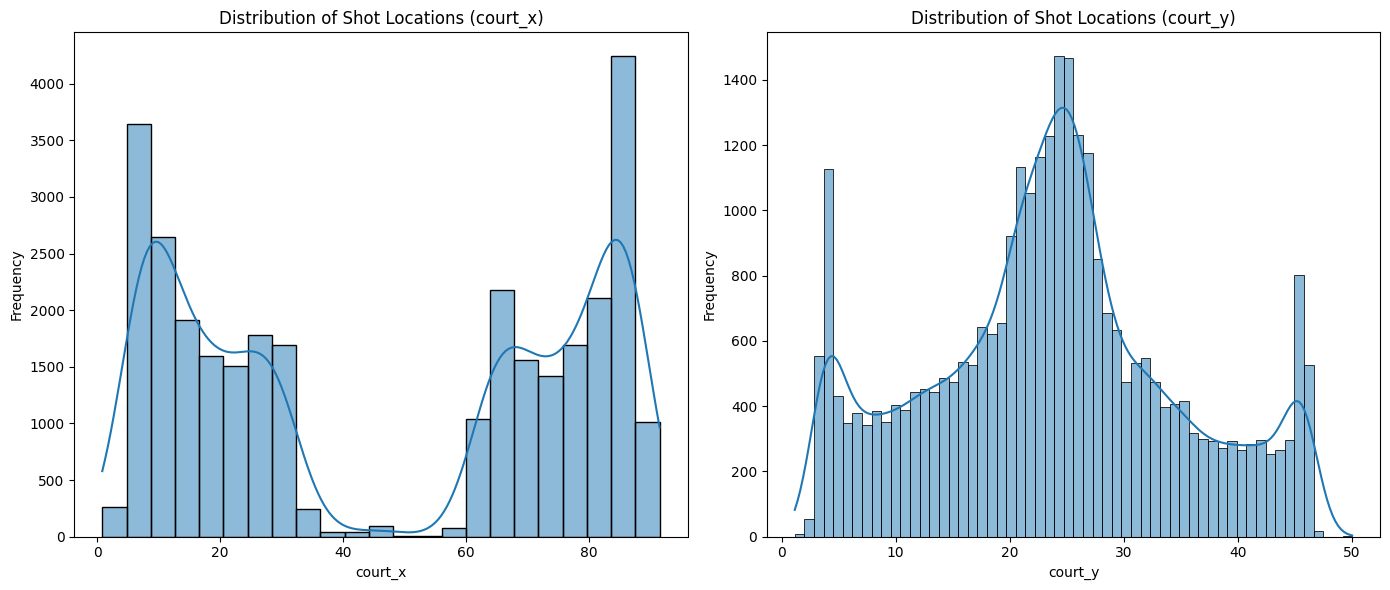

In [16]:
# Assuming you've already loaded your dataframe as 'df'

# 1.1 Univariate Analysis:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1.1.1 Shot Locations:
sns.histplot(shooter_data_train['court_x'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Shot Locations (court_x)')
axes[0].set_xlabel('court_x')
axes[0].set_ylabel('Frequency')

sns.histplot(shooter_data_train['court_y'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Shot Locations (court_y)')
axes[1].set_xlabel('court_y')
axes[1].set_ylabel('Frequency')


plt.tight_layout() # Adjusts the plots so that they fit well
plt.show()


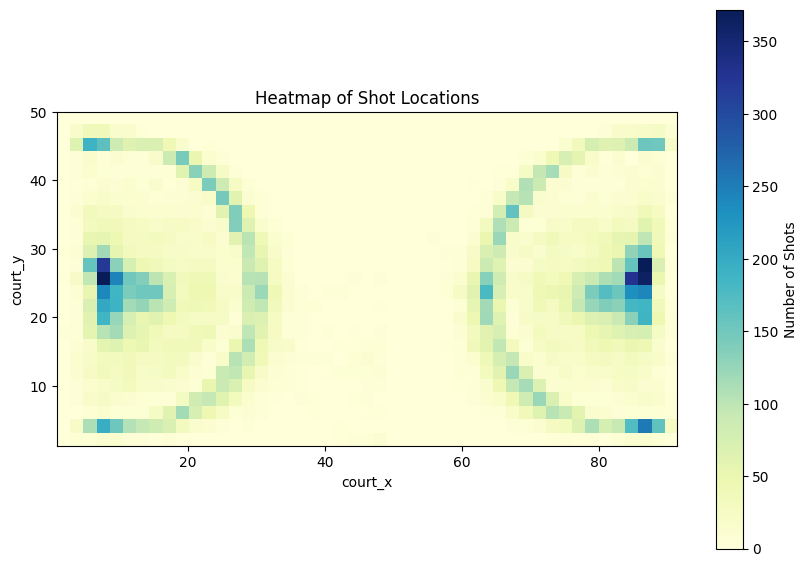

In [793]:
# Define grid size for binning
grid_size = 2

# Use numpy's histogram2d to bin the data
hist, xedges, yedges = np.histogram2d(shooter_data_train['court_x'], shooter_data_train['court_y'], bins=(int(94/grid_size), int(50/grid_size)))

# Plot heatmap
plt.figure(figsize=(10, 7))
plt.imshow(hist.T, origin='lower', cmap='YlGnBu', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Number of Shots')
plt.title('Heatmap of Shot Locations')
plt.xlabel('court_x')
plt.ylabel('court_y')
plt.show()

#### **Distribution of Shot Locations Analysis:**
- Trends Observed: 
    - There are very few shots taken (and missed) from mid-court.
    - The highest concentration of shots are near the basket
    - Mid-range shots are the least common shots
    - Interestingly, there are more shots missed on the left side of the basket up close on one side of the court
        - This can be assumed not to be a trend worth investigating given what we know about basketball
        - This sheds light on the limitations of the size of the dataset

### **Frequency of Offensive vs. Defensive Rebounds**

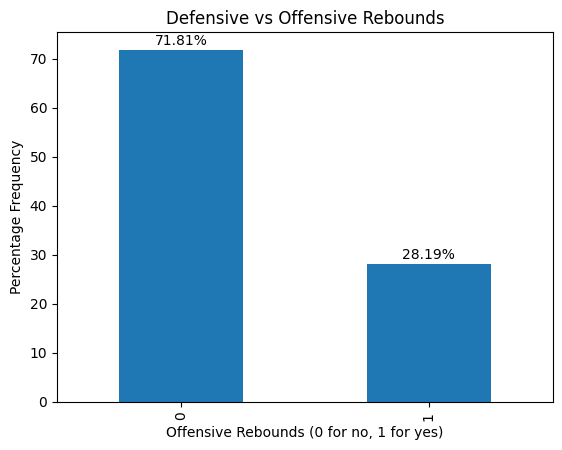

In [27]:
# Your initial code
oreb_counts = shooter_data_train['is_oreb'].value_counts(normalize=True)  # Normalize will give the fraction (proportion)
oreb_counts_percentage = (oreb_counts * 100).round(2)  # Convert to percentage and round off to two decimal points

ax = oreb_counts_percentage.plot(kind='bar')
plt.title('Defensive vs Offensive Rebounds')
plt.xlabel('Offensive Rebounds (0 for no, 1 for yes)')
plt.ylabel('Percentage Frequency')

# Annotate bars with their percentage values
for index, value in enumerate(oreb_counts_percentage):
    ax.text(index, value + 1, str(value) + '%', ha='center')  # "+ 1" to position text above bars slightly

plt.show()


#### **Rebound Type Frequencies Analysis:**
- Trends Observed: 
    - We have an imbalanced dataset as most rebounds (`71.81%`) are defensive rebounds as expected
    - It could be beneficial to experiment with oversampling

---

## **Bivariate Analysis**

### **Shooting Position vs Offensive Rebounds**

In [33]:
shooter_data_train = shooter_data_train.merge(train_pbp[['id', 'is_oreb']], on='id')

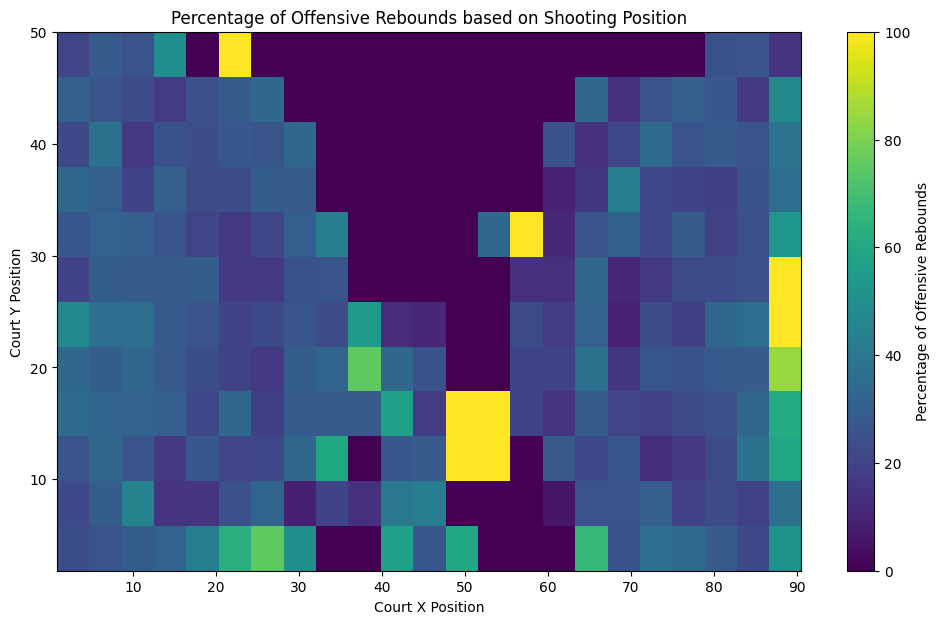

In [36]:
# Define the grid size for binning
grid_size = 4

# 1. Histogram for shots resulting in offensive rebounds
oreb_hist, xedges, yedges = np.histogram2d(
    shooter_data_train[shooter_data_train['is_oreb'] == 1]['court_x'], 
    shooter_data_train[shooter_data_train['is_oreb'] == 1]['court_y'], 
    bins=(94//grid_size, 50//grid_size)
)

# 2. Histogram for all shots
all_shots_hist, _, _ = np.histogram2d(
    shooter_data_train['court_x'], 
    shooter_data_train['court_y'], 
    bins=(94//grid_size, 50//grid_size)
)

# 3. Calculate the percentage of offensive rebounds in each bin
percentage_oreb = np.where(all_shots_hist != 0, (oreb_hist / all_shots_hist) * 100, 0)

# Plot heatmap
plt.figure(figsize=(12, 7))
plt.imshow(percentage_oreb.T, origin='lower', aspect='auto', cmap='viridis', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=100)
plt.colorbar(label='Percentage of Offensive Rebounds')
plt.title('Percentage of Offensive Rebounds based on Shooting Position')
plt.xlabel('Court X Position')
plt.ylabel('Court Y Position')
plt.show()


#### **Shooting Position vs Offensive Rebounding Heatmap Analysis:**
- Trends Observed: 
    - It seems mid range jumpshots tend to be the worst shots for obtaining an offensive rebound (inefficient for yet another reason)
    - There are small pockets of the court that have extremely high offensive rebounding rates, but referring back to our heatmap from before, these pockets are small samples

### **Shot Distance from Hoop vs. Offensive Rebounds**:

posx and posy should be finite values
posx and posy should be finite values


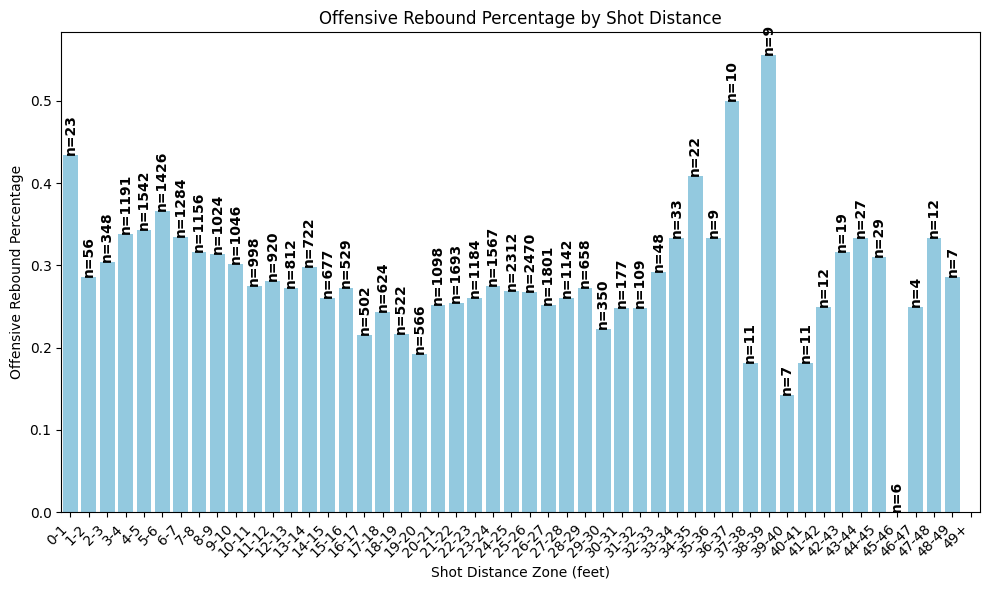

In [39]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins cut by 2 feet
shot_distance_bins = [x for x in range(0, 51, 1)]

# Update the zone_labels accordingly
zone_labels = [f'{dist}-{dist+1}' for dist in shot_distance_bins[:-1]]
zone_labels[-1] = f'{shot_distance_bins[-2]}+'
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts().reindex(zone_labels, fill_value=0)

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone.iloc[index]}', ha='center', va='bottom', fontweight='bold', rotation='vertical')

plt.tight_layout()
plt.show()


#### **Shot Distance from Hoop vs. Offensive Rebounds:**
- Trends Observed: 
    - More evidence that mid range jumpshots tend to be the worst shots for obtaining an offensive rebound
    - Shots very close to the basket may be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher
    - Shots greater than 21 feet have a higher rebound rate than shots from 16-21 feet in the training data
        - This could be because longer shots lead to longer rebounds

Binning shot distances into zones may be beneficial because similar shots types are likely taken in each zone, so shot distance may have a complex relationship with offensive rebounding

#### *Proposed Shot Zone Bins:* 0-7, 7-11, 11-17, 17-21, 21+

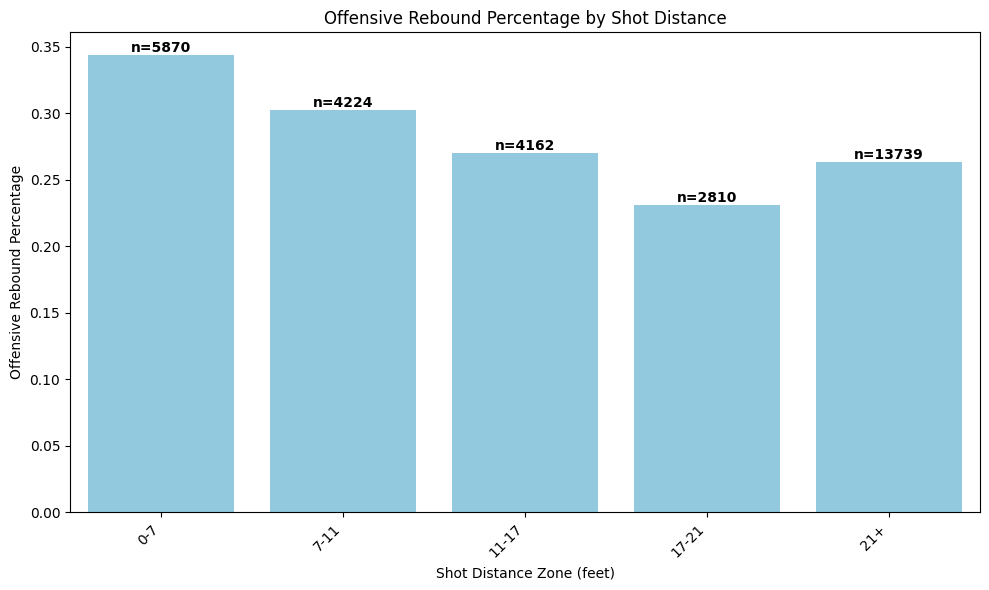

In [48]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins
shot_distance_bins = [0, 7, 11, 17, 21, np.inf]

# Define the zone labels accordingly
zone_labels = ['0-7', '7-11', '11-17', '17-21', '21+']

shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### **Shot Distance from Hoop Frequency Distribution Analysis:**
The zones are fairly distinct in offensive rebounding percentage, but some sample sizes are small, so it is important to experiment with different bins
- For use in modeling experimentation later on, I create dataframes that one-hot-encode the plays based on these 5 bins

In [50]:
# Categorize 'shooter_dist_from_hoop' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# Perform One-Hot Encoding for the 'shot_distance_zone' column
df_encoded_5bins_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_5bins_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

#### *Alternative Shot Zone Bins:* 0-11, 11-21, 21+

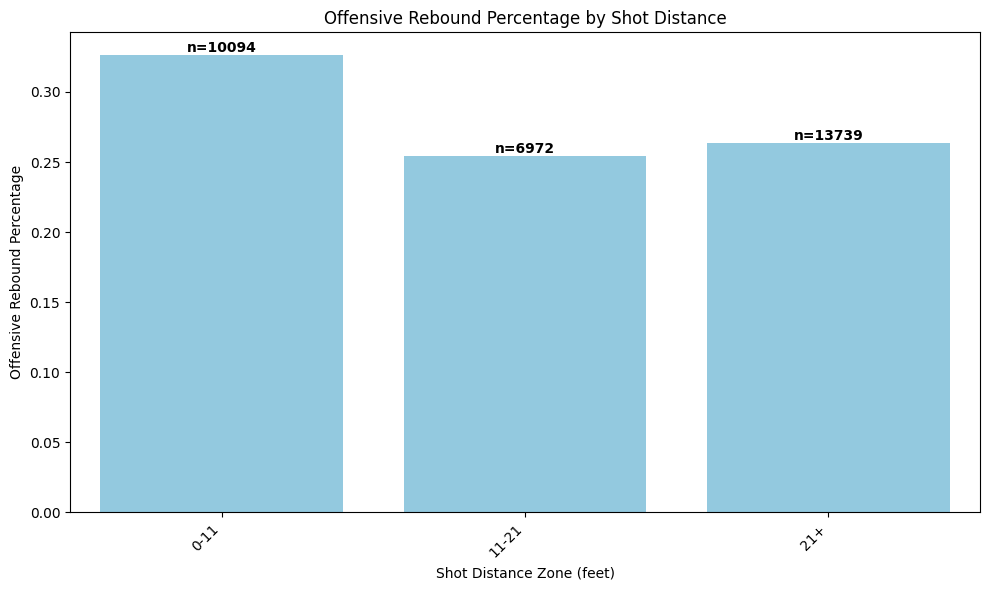

In [51]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins
shot_distance_bins = [0, 11, 21, np.inf]

# Define the zone labels accordingly
zone_labels = ['0-11', '11-21', '21+']

shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### **Shot Distance from Hoop Frequency Distribution Analysis:**
These zones are more generalized, potentially benefiting the model by minimizing noise. They categorize shots as close range, mid-range, and long range.

- The relationship between player proximity to the basket and offensive rebounding might vary across these zones. This is because longer shots tend to result in longer rebounds.

In [53]:
# Categorize 'shooter_dist_from_hoop' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# Perform One-Hot Encoding for the 'shot_distance_zone' column
df_encoded_3bins_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_3bins_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

### **Calculating Distance of Defenders, Offensive Players from the basket**
- This feature will inform the spacing of the court at the time of the shot
- If the defense is further out, it may make it harder to box out and the more lanes there will be for offensive players to crash the boards


In [54]:
def calculate_distance_from_hoop(row):
    # Define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]])  # Ensure the elements are floats
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # Calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [55]:
# Merging the information we have learned about which hoop is being shot at back to the training set
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

In [73]:
def process_defender_distances(df, offense):
    """
    Processes the input dataframe for players, calculates their distances from the hoop,
    ranks them by distance, and pivots the data to create features for the closest 
    players to the hoop.
    
    Parameters:
    - df (pandas.DataFrame): Input dataframe with player data.
    - offense (int): 1 for offense 0 for defense.
    
    Returns:
    - pandas.DataFrame: Processed dataframe with ranked distances.
    """
    
    # Filter dataframe for defenders only
    distance = df.loc[df.offense == offense].copy()
    
    # variable for prefix
    prefix = 'off' if offense == 1 else 'def'

    # Calculate [;ayer] distance from hoop
    distance[f'{prefix}_distance'] = distance.apply(calculate_distance_from_hoop, axis=1)
    
    # Rank the players within each play (id) by distance from the hoop
    distance['rank'] = distance.groupby('id')[f'{prefix}_distance'].rank(method='first')

    # calculating mean distance from the hoop; groupby will resort by id the same way the rank calc does
    mean_dists = distance.groupby('id')[f'{prefix}_distance'].mean()
    
    # Pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
    df_pivot = distance.pivot_table(index='id', columns='rank', values=f'{prefix}_distance').add_prefix(prefix + '_').reset_index()
    
    # Rename the columns to be more descriptive
    df_pivot.columns = ['id'] + [f'closest_{prefix}_to_hoop', f'second_closest_{prefix}_to_hoop', f'third_closest_{prefix}_to_hoop', f'fourth_closest_{prefix}_to_hoop', f'fifth_closest_{prefix}_to_hoop']
    
    # Fill missing values (if any) with a specific value, e.g., -1
    df_pivot.fillna(-1, inplace=True)

    # inserting mean values as a column
    df_pivot[f'{prefix}_distance_mean'] = mean_dists.values
    
    return df_pivot


In [74]:
# Pivots the data so there is one row per play
def_pivot = process_defender_distances(training_data, 0)
off_pivot = process_defender_distances(training_data, 1)
def_pivot_test = process_defender_distances(testing_data, 0)
off_pivot_test = process_defender_distances(testing_data, 1)

In [87]:
def_pivot.head()

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean
0,10-10,9.272356,10.056615,12.992872,14.782542,16.175073,12.655892
1,10-12,3.087682,4.322785,10.780686,15.429233,16.502760,10.024629
2,10-13,5.753939,12.180877,12.535084,14.027878,22.990277,13.497611
3,10-3,5.824702,10.965734,13.980346,17.154582,22.102294,14.005532
4,10-6,7.887358,11.555978,11.713705,17.826780,30.140720,15.824908


In [88]:
off_pivot.head()

,id,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,10-10,10.328278,15.046402,23.173309,25.311266,26.103727,19.992596
1,10-12,4.132574,17.754600,20.971792,23.246796,25.166567,18.254466
2,10-13,8.968685,17.949111,21.778384,23.195872,25.221159,19.422642
3,10-3,7.958549,13.436814,22.160137,24.473980,25.763053,18.758507
4,10-6,17.564172,21.746126,24.109830,25.010259,28.569046,23.399887


In [89]:
# combining the player distance dataframe on play id
pivot_train = def_pivot.merge(off_pivot, on='id')
pivot_test = def_pivot_test.merge(off_pivot_test, on='id')
pivot_train = pivot_train.merge(train_pbp[['id', 'is_oreb']], on='id')

### **Exploring Player Distance to the Basket relationships with Offensive Rebounding**

In [103]:
pd.DataFrame(pivot_train.corr()['is_oreb'])

,is_oreb
closest_def_to_hoop,-0.045311
second_closest_def_to_hoop,-0.056003
third_closest_def_to_hoop,-0.051258
fourth_closest_def_to_hoop,-0.039862
fifth_closest_def_to_hoop,-0.012574
def_distance_mean,-0.046557
closest_off_to_hoop,-0.093529
second_closest_off_to_hoop,-0.128443
third_closest_off_to_hoop,-0.104975
fourth_closest_off_to_hoop,-0.054370


#### **Correlation Chart Analysis**
The second closest offensive player has the highest absolute correlation to offensive rebounding (`-.128`), followed by the offensive mean (`-.111`), the third closest off player (`-.105`), and the closest offensive player (`-.093`)
- This trend may indicate that having multiple rebounders near the basket is crucial to securing an offensive rebound
Each defender distance also has a negative correlation with offensive rebounding, suggesting that defenders are actually further from the basket when they secure defensive rebounds as opposed to when there is an offensive rebound
- This trend may be due to the fact that the area of the floor with the highest offensive rebounding percentage is up close shots, so defenders are likely drawn inward to contest the shot
- It is unlikely that being further from the rim is beneficial to defensive rebounding, so this is an important note
- Defender distance can still be a valuable feature when the model considers its relationship with shot distance zones

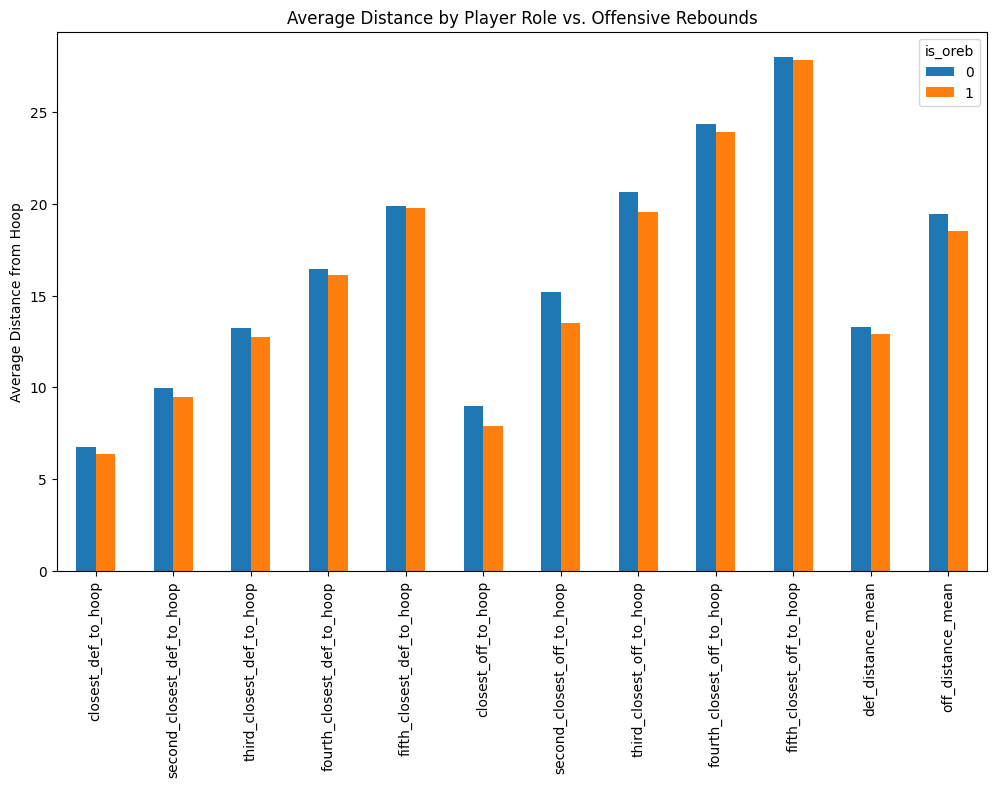

In [111]:
grouped = pivot_train.groupby('is_oreb').mean()[['closest_def_to_hoop', 'second_closest_def_to_hoop',
       'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop',
       'fifth_closest_def_to_hoop', 'closest_off_to_hoop',
       'second_closest_off_to_hoop', 'third_closest_off_to_hoop',
       'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop', 'def_distance_mean', 'off_distance_mean']]
grouped.transpose().plot(kind='bar', figsize=(12, 7))
plt.title('Average Distance by Player Role vs. Offensive Rebounds')
plt.ylabel('Average Distance from Hoop')
plt.show()


#### **Average Distance by Player Role vs Offensive Rebounds Analysis:**

1. Distance of Closest Defender:
    - For plays where an offensive rebound (`is_oreb=1`) occurred, the closest defender tends to be slightly closer to the hoop (`6.37` feet) as compared to plays where there was no offensive rebound (`6.73` feet). 
    - *Insight*: This requires some further investigation and how shot_distance_zone plays a role

2. Other Defenders:
    - A similar trend continues for the `second`, `third`, `fourth`, and `fifth` closest defenders. They all tend to be closer to the hoop during successful offensive rebounds than during unsuccessful ones.
    - *Insight*: The positioning of the entire defense close to the hoop seems to correlate with higher offensive rebound success. This might indicate that a condensed defensive formation creates more opportunities for offensive rebounds.

3. Distance of Closest Offensive Player:
    - When an offensive rebound is successful, the closest offensive player is on average closer to the hoop (`7.91` feet) than in unsuccessful attempts (`8.95` feet).
    - *Insight*: Being closer to the hoop increases the chances of grabbing an offensive rebound. Offensive strategies might benefit from ensuring that at least one player is near the hoop during shots.

4. Other Offensive Players:
    - Just like with defenders, other offensive players (`second` to `fifth` closest) are generally closer to the hoop in plays with successful offensive rebounds.
    - *Insight*: It seems that having multiple offensive players close to the hoop enhances the team's chance of securing an offensive rebound. This could suggest the importance of aggressive offensive positioning during shooting attempts.

5. Overall Defensive vs. Offensive Presence:
    - Comparing the mean distances, defenders are generally closer to the hoop than offensive players. However, the gap is smaller in successful offensive rebound scenarios.
    - *Insight*: Defensive teams often position themselves between the offensive players and the hoop. However, reducing the distance gap between offensive players and defenders appears to be a key factor in successful offensive rebounds.

6. Strategic Takeaways:
    - Having multiple players near the basket is important to the offense's chance at securing an offensive rebound


### **Breaking mean defender distance down by shot_distance_zones**
- Here, we investigate the hypothesis that defender distance correlates negatively with offensive rebounding because they will naturally be closer to the basket on shots from close range which result in more offensive rebouns

In [114]:
pd.set_option('display.max_columns', None)

In [127]:
def_mean_vis_data = pivot_train.merge(df_encoded_5bins_train[['id', 'shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+']], on='id')

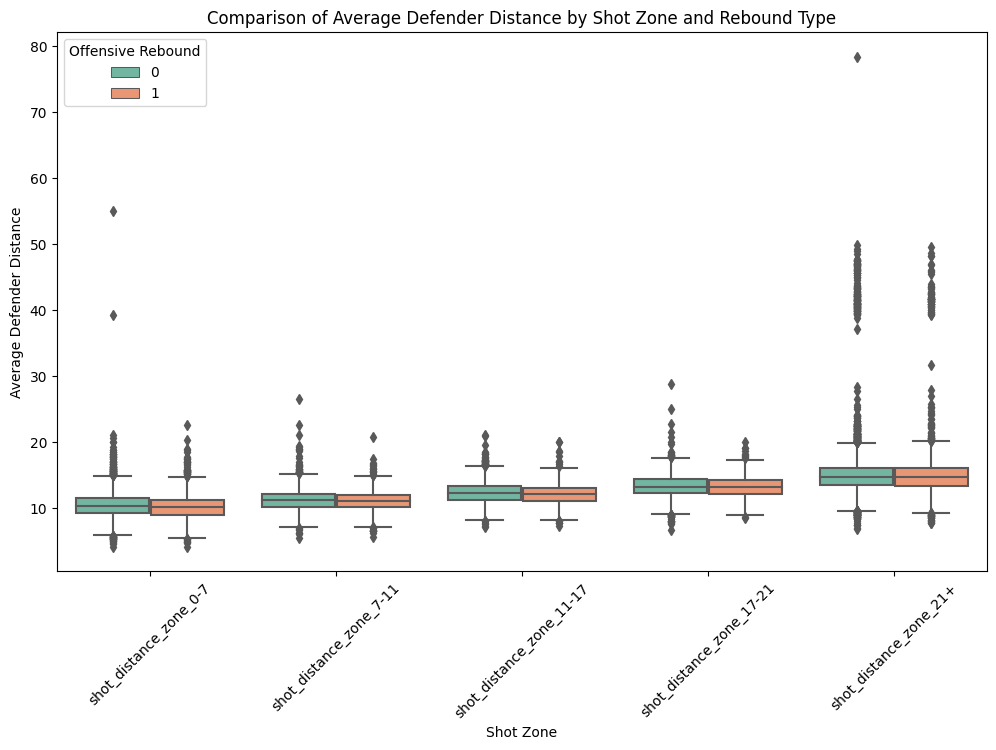

In [129]:
# Melt the dataframe for shot zones to get them in a single column
df_melted = def_mean_vis_data.melt(id_vars=['def_distance_mean', 'is_oreb'], 
                    value_vars=['shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+'],
                    var_name='shot_zone', value_name='zone_value')

# Filter only the rows where zone_value is 1
df_melted = df_melted[df_melted['zone_value'] == 1]

plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='shot_zone', y='def_distance_mean', hue='is_oreb', data=df_melted, palette="Set2")
plt.title('Comparison of Average Defender Distance by Shot Zone and Rebound Type')
plt.ylabel('Average Defender Distance')
plt.xlabel('Shot Zone')
plt.xticks(rotation=45)
plt.legend(title='Offensive Rebound')
plt.show()


- This plot helped identify an potential outlier with a defensive rebound occuring with an average defender distance from the hoop of ~80 ft which seems highly unlikely (Potential Roscoe Smith situation)
- Outliers in average defender distance are likely unsuccessful shot attempts on fast break opportunities; Average defender distance > 20 is a probable fast break
- Let's use a bar plot instead to better understand the relationship we are investigating

<img src="Roscoe Smith.png" width="400" alt="Alternative text for the image">

#### **Defender Distance by Shot Zone vs Offensive Rebounding**

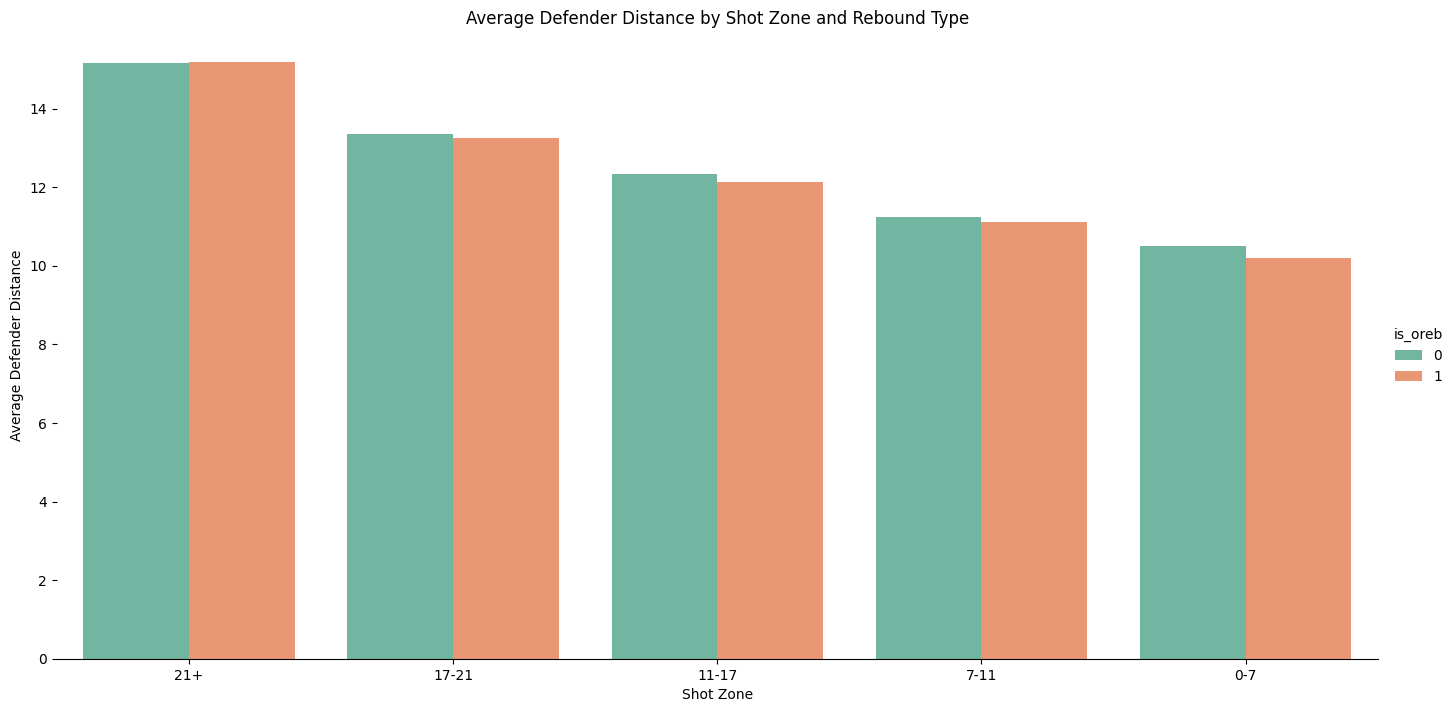

In [800]:
# Create a new DataFrame to calculate the means
means_df = def_mean_vis_data.groupby(['is_oreb', 'shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+'])['def_distance_mean'].mean().reset_index()

# Create a 'shot_zone' column to store the zone labels based on the new zones
means_df['shot_zone'] = '0-7'
means_df.loc[means_df['shot_distance_zone_7-11'] == 1, 'shot_zone'] = '7-11'
means_df.loc[means_df['shot_distance_zone_11-17'] == 1, 'shot_zone'] = '11-17'
means_df.loc[means_df['shot_distance_zone_17-21'] == 1, 'shot_zone'] = '17-21'
means_df.loc[means_df['shot_distance_zone_21+'] == 1, 'shot_zone'] = '21+'

g = sns.catplot(x='shot_zone', y='def_distance_mean', hue='is_oreb', data=means_df, kind='bar', palette="Set2", height=7, aspect=2)
g.despine(left=True)
g.set_axis_labels("Shot Zone", "Average Defender Distance")

plt.title('Average Defender Distance by Shot Zone and Rebound Type')
plt.show()


As hypothesized, defenders distance to the rim on long range shots is on average closer for defensive rebounds than offensive (very narrowly, 15.16 ft to 15.18 ft)
- This contrasts with the idea that longer shots will lead to longer rebounds, so we will need to engineer features that can better contextualize the optimal defender position in relation to the hoop to be used in conjuction with defender distance

In [794]:
df_encoded_3bins_train.head(3)

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number,is_oreb,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+
0,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2,0,0,0,1
1,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3,0,0,1,0
2,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4,0,0,0,1


#### **Merging shot distance zone data and player distance to the hoop data to build a baseline model**

In [194]:
df_encoded_train_5bins = df_encoded_5bins_train.merge(pivot_train.drop(columns='is_oreb'), on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 
                                                                                                                'shooter_dist_from_hoop', 'which_hoop', 'game_number', 'play_number'], axis=1)
df_encoded_test_5bins = df_encoded_5bins_test.merge(pivot_test, on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'shooter_dist_from_hoop', 'which_hoop'], axis=1)

In [195]:
df_encoded_train_3bins = df_encoded_3bins_train.merge(pivot_train.drop(columns='is_oreb'), on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 
                                                                                                                'shooter_dist_from_hoop', 'which_hoop', 'game_number', 'play_number'], axis=1)
df_encoded_test_3bins = df_encoded_3bins_test.merge(pivot_test, on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'shooter_dist_from_hoop', 'which_hoop'], axis=1)

In [795]:
df_encoded_train_5bins.head(3)

,id,is_oreb,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21+,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,2-2,0,0,0,0,0,1,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,24.810706,33.674014,20.537458
1,2-3,0,0,0,0,1,0,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,25.787367,27.439075,22.426203
2,2-4,0,0,0,0,0,1,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,27.413357,34.175635,22.744289


#### **Scaling the Data**

In [234]:
def scale_distances(df, df_test, zones):
    # Create a StandardScaler object
    # Using a StandardScaler (instead of MinMax) to reduce the impact of outliers
    scaler = StandardScaler()

    data = df.copy()
    data_test = df_test.copy()
    # Extract the continuous features from the DataFrame
    continuous_features = data.iloc[:, zones + 2:]  # the continuous features start from the 10th column
    continuous_features_test = data_test.iloc[:, zones + 1:]

    # Fit and transform the continuous features using the StandardScaler
    # Fitting on the train set only
    scaled_continuous_features = scaler.fit_transform(continuous_features)
    scaled_continuous_features_test = scaler.transform(continuous_features_test)

    # Convert the scaled_continuous_features back to a DataFrame with the original column names
    scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
    scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

    # Concatenate the scaled continuous features with the categorical features (if any)
    # Use the appropriate columns indices depending on your DataFrame structure
    data = pd.concat([data.iloc[:, :zones + 2:], scaled_continuous_df], axis=1)
    data_test = pd.concat([data_test.iloc[:, :zones + 1], scaled_continuous_df_test], axis=1)
    return data, data_test

In [235]:
# Scaling dataframes
X_dist_3bins, X_test_dist_3bins = scale_distances(df_encoded_train_3bins, df_encoded_test_3bins, 3)
X_dist_5bins, X_test_dist_5bins = scale_distances(df_encoded_train_5bins, df_encoded_test_5bins, 5)

In [796]:
X_dist_5bins.head(3)

,id,is_oreb,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21+,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,2-2,0,0,0,0,0,1,0.280024,0.707359,1.194021,0.876404,0.314668,0.786057,0.394397,-0.562562,0.385818,0.156934,1.509469,0.383356
1,2-3,0,0,0,0,1,0,0.090078,-0.208605,0.106853,-0.320979,-1.069568,-0.331162,1.759438,1.021993,0.090994,0.426478,-0.133723,0.914279
2,2-4,0,0,0,0,0,1,0.266573,-0.283265,1.035903,2.081879,1.751264,1.140872,-0.564888,1.161601,0.967612,0.875227,1.641669,1.003692


In [239]:
# finalizing X and y by removing id and the target from X
y_dist = X_dist_3bins['is_oreb']
X_dist_3 = X_dist_3bins.drop(columns=['id', 'is_oreb'])
X_dist_5 = X_dist_5bins.drop(columns=['id', 'is_oreb'])

### **Model Choice**

For our analysis on the relationship between player positions, shot distances, and the likelihood of offensive rebounds, I opted for the XGBoost algorithm. XGBoost, which stands for eXtreme Gradient Boosting, is renowned for its efficiency and performance, frequently standing out in machine learning competitions. The key reasons for this choice include:

1. *Ensemble Learning*: XGBoost operates on the gradient boosting framework, which builds an ensemble of weak prediction models, typically decision trees. This ensemble approach is especially adept at tackling complex datasets like ours, where interactions between features (like player positions and shot distances) are nuanced.

2. *Regularization*: Unlike many other tree-based algorithms, XGBoost incorporates L1 (Lasso Regression) and L2 (Ridge Regression) regularization. This ensures that our model doesn't overfit to the training data, a common concern when working with intricate sports datasets that contain multifaceted relationships.

3. *Flexibility*: XGBoost can be easily integrated with other machine learning frameworks and is amenable to a range of hyperparameter tuning options. This flexibility ensures we can optimize the model for our specific task and dataset.

In summary, given the intricacies of our basketball analysis and the inherent challenges in predicting rebounds, XGBoost emerged as a natural choice due to its robustness, efficiency, and adaptability.

In [240]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_dist_3, y_dist, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5811479984473633


In [241]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_dist_5, y_dist, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5809927158531752


### **Analyzing XGBoost Model Performance Across Different Shot Distance Zones**

When building a predictive model, especially in sports analytics where the granularity of data can offer rich insights, it's essential to experiment with how we segment or categorize our features. In basketball, the shot distance, given its evident influence on player positions and strategies, serves as an ideal feature for such experimentation.

#### Results:

- *3 Shot Distance Zones*: This broader categorization yielded an Average Log Loss of **0.58115**.
- *5 Shot Distance Zones*: A more detailed categorization resulted in a slightly better Average Log Loss of **0.58099**.

### Discussion:

The difference in performance between the two categorizations is marginal. This could suggest a few points:

1. The addition of two more shot distance zones offers only a slight enhancement in our model's predictive accuracy. 
2. The improvement in the 5-zone model might be attributed to capturing more intricate relationships in the data. However, the near-identical performance indicates our XGBoost model might already be capturing most of the variance with just the three zones.
3. Given the negligible difference in Log Loss, we should weigh the benefits of a finer granularity against its potential costs in terms of complexity and interpretability.

#### Recommendations:

While the model with 5 shot distance zones marginally outperforms its counterpart, we should consider the broader implications. Simpler models, like the 3-zone one, could be preferable for their ease of interpretation, especially when liaising with stakeholders less familiar with data intricacies. However, if the primary goal is to maximize predictive accuracy, then every small advantage, such as that provided by the 5-zone model, becomes valuable.


In [798]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=3)
model.fit(X_dist_5, y_dist)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### **Analyzing Feature Importances in Predicting Offensive Rebounds**

In the realm of basketball analytics, understanding feature importances not only aids in model interpretability but also provides deeper insights into on-court dynamics and strategies. The XGBoost model has provided the following feature importances for predicting offensive rebounds:

In [243]:
def plot_feat_importances(columns, feature_importances):
    # Plot
    plt.figure(figsize=(10, len(columns)/2))  # Adjust the figure size
    plt.title('Feature Importances')
    plt.barh(columns, feature_importances)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

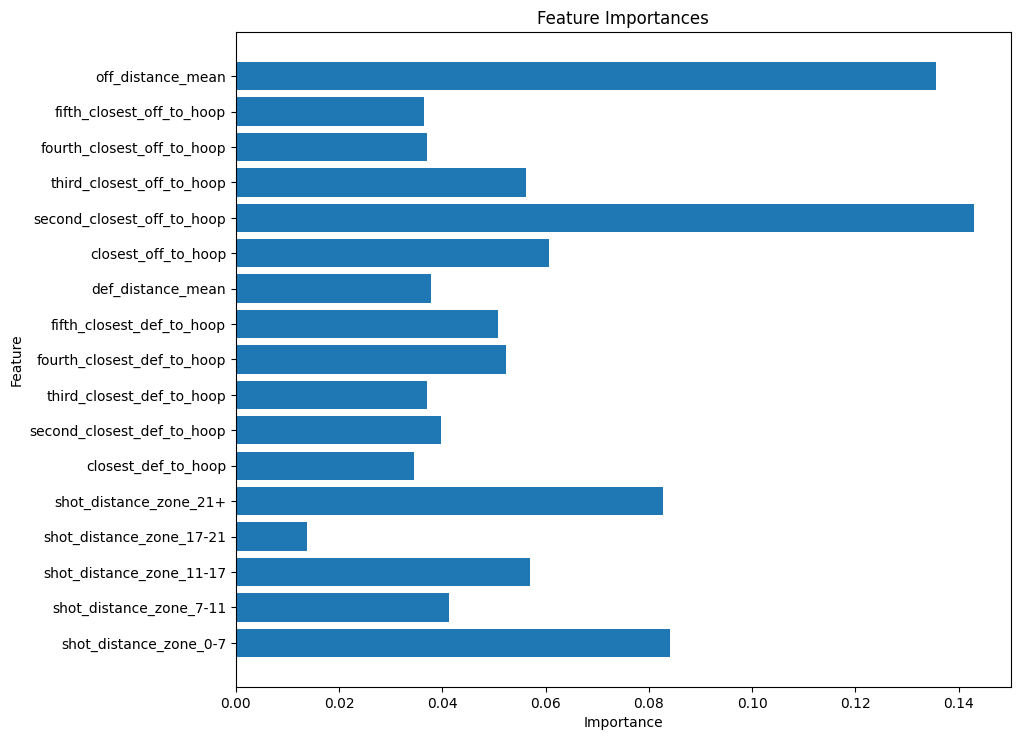

In [245]:
plot_feat_importances(X_dist_5.columns, model.feature_importances_)



#### **Key Feature Importance Insights**:

1. Shot Distance Zones:
    - **0-7 feet (0.0841)**: This zone, closest to the basket, is crucial in predicting offensive rebounds, likely due to many shots and subsequent rebound opportunities occurring here.
    - **7-11 feet (0.0413)** and **11-17 feet (0.0570)**: These mid-range distances show moderate importance. The decrease in importance from the closest zone may indicate fewer shots from this area or different rebound dynamics.
    - **17-21 feet (0.0138)**: Reduced importance here may reflect fewer shot attempts from this distance.
    - **21+ feet (0.0828)**: Despite being farther, this zone's importance is nearly on par with the closest zone, suggesting the long rebounds from 3-pointers play a significant role.

2. Defensive Players' Distance to Hoop:
    - The distances of the individual defensive players (ranging from **0.0346 to 0.0522**) show similar levels of importance. This underscores the team aspect of defensive rebounding, where positioning of all players matters.
    - **Defensive Mean Distance (0.0379)**: The average distance of defenders showcases their collective positioning, and its significance might indicate the defensive setup during shots.

3. Offensive Players' Distance to Hoop:
    - **Second Closest Offensive Player to Hoop (0.1430)**: This stands out as the most influential feature. It indicates that while the closest offensive player is vital, having a second player nearby is crucial for securing offensive rebounds.
    - **Offensive Mean Distance (0.1357)**: This emphasizes the collective effort on the offensive boards, suggesting a balanced offensive rebounding approach is fruitful.
    - Other offensive players' distances also hold relevance, with values around **0.036 to 0.0606**, highlighting the importance of team positioning.


---

# **Complex Feature Engineering**
To this point we have constructed a high performing model using distances of shots and players from the basket. The next step will be to incorporate angles and relative positions to get a better sense of how well teams are positioned for rebounds at the time of a shot. There will be in depth explanations of the rationale for each feature engineered. Feature importance scores and visualizations will be the primary tools for assessing the effectiveness of each feature.

## **Assigning box out responsibilities**

*Offensive Rebounding Player Assignment Algorithm*

Understanding which players are most likely to box out one another is crucial to understanding the chances of an offensive rebound. If an offensive player is in front of a defensive player, this cannot be captured by a distance to the hoop metric without knowing which players will be competing with each other for position. To optimally choose which offensive player a defensive rebounder should box out, I will use the distance from defensive player to the offensive player and the betweenness centrality of the offensive player. Offensive players closer to the hoop will be prioritized by using betweenness centrality because there will be edges connecting offensive players to the hoop with weights reflecting the inverse of their distance.

This algorithm is designed to optimize the assignment of defensive players to their respective offensive players during a basketball game to enhance the team's chances of securing an defensive rebound.

Step 1: Creating a Spatial Graph

The algorithm starts by constructing a spatial graph that represents the relationships between offensive players and the hoop (basket). Each player and the hoop are represented as nodes in the graph, and edges are added between offensive players based on their spatial proximity. This graph reflects the players' positioning on the court and helps identify the most strategic offensive players to box out.

Step 2: Betweenness Centrality

The algorithm then calculates a measure called 'betweenness centrality' for each offensive player in the graph. This metric quantifies how often an offensive player lies on the shortest path between other offensive players and the hoop. High betweenness centrality indicates that a player is in a critical position on the court, and boxing out such players becomes crucial for effective rebounding. In basketball terms, offensive players with high betweenness centrality are in critical positions that can impact the overall offensive flow and create more scoring opportunities. Therefore, these players become important targets for defensive players to box out and prevent them from securing offensive rebounds.

Step 3: Optimizing Player Assignments

Next, the algorithm aims to optimize the assignment of defensive players to offensive players. To achieve this, it creates a cost matrix that considers both the distance between defensive and offensive players and the offensive players' betweenness centrality. The Hungarian algorithm is then employed to find the best possible player assignments that maximize the overall betweenness centrality while minimizing the distances.

Step 4: Iterative Refinement

To further improve the assignments, the algorithm iteratively updates the player assignments and optimizes the betweenness centrality and distances. This iterative refinement process enhances the quality of player matchups, ensuring that no defensive player is left without a specific offensive player to box out.

Step 5: Assigning Remaining Defenders

After the iterations, there may still be some defenders without an offensive player assigned to them. To address this, the algorithm finds the closest unassigned offensive player for each remaining defender based on the distances.

In [246]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_graph(offensive_players_, hoop, distances):
    graph = nx.Graph()
    for player1 in offensive_players_:
        for player2 in offensive_players_:
            if not np.array_equal(player1, player2):
                distance = calculate_distance(player1, player2)
                graph.add_edge(tuple(player1), tuple(player2), weight=1.0 / distance)
        distance_to_hoop = distances[(tuple(player1), tuple(hoop))]
        graph.add_edge(tuple(player1), tuple(hoop), weight=1.0 / distance_to_hoop)
    
    return graph

def calculate_betweenness_centralities(graph):
    return nx.betweenness_centrality(graph, weight='weight')

def calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities):
    num_defenders = len(defenders_)
    num_offensive_players = len(offensive_players_)
    cost_matrix = np.zeros((num_defenders, num_offensive_players))

    for i, defender in enumerate(defenders_):
        for j, offensive_player in enumerate(offensive_players_):
            distance_cost = distances[(tuple(defender), tuple(offensive_player))]
            betweenness_cost = -betweenness_centralities[tuple(offensive_player)]
            # Betweenness centralities are between 0 and 1, so multiplying by a factor of 5 to emphasize its cost
            cost_matrix[i, j] = distance_cost + 5 * betweenness_cost

    return cost_matrix

def assign_offensive_players(defenders_, offensive_players_, hoop, num_iterations=5):
    distances = {}
    for defender in defenders_:
        for offensive_player in offensive_players_:
            distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
        distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, hoop)

    for offensive_player in offensive_players_:
        distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, hoop)

    assignments = {}
    centralities_store = {} # A dictionary to store betweenness centralities for each iteration
    unassigned_defenders = list(defenders_)

    for _ in range(num_iterations):
        graph = construct_graph(offensive_players_, hoop, distances)
        betweenness_centralities = calculate_betweenness_centralities(graph)
        centralities_store.update(betweenness_centralities)  # Store the betweenness centralities

        cost_matrix = calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            defender = tuple(defenders_[i])
            offensive_player = tuple(offensive_players_[j])
            assignments[defender] = offensive_player
            if any(np.array_equal(defender, a) for a in unassigned_defenders):
                unassigned_defenders = [x for x in unassigned_defenders if not (x == defender).all()]

    for defender in unassigned_defenders:
        min_distance = float('inf')
        closest_offensive_player = None
        for offensive_player in offensive_players_:
            distance = distances[(tuple(defender), tuple(offensive_player))]
            if distance < min_distance:
                min_distance = distance
                closest_offensive_player = tuple(offensive_player)
        assignments[tuple(defender)] = closest_offensive_player

    return assignments, centralities_store

# Example usage:
defenders = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
offensive_players = np.array([[5, 0], [6, 1], [7, 2], [8, 3], [9, 4]])
hoop = np.array([10, 5])

assignments = assign_offensive_players(defenders, offensive_players, hoop)
print(assignments)

({(0, 0): (5, 0), (1, 1): (6, 1), (2, 2): (7, 2), (3, 3): (8, 3), (4, 4): (9, 4)}, {(5, 0): 0.25, (6, 1): 0.0, (7, 2): 0.0, (8, 3): 0.0, (9, 4): 0.0, (10, 5): 0.25})


In [247]:
# Making copies of the dataset to be used in assigning responsibilities
copy_training_data = training_data.copy()
copy_testing_data = testing_data.copy()

In [249]:
def assign_responsibilities(data):
    grouped_data = data.groupby('id')
    assignments_list = []
    centralities_list = []
    list_of_ids = []

    for id, group in grouped_data:
        defenders_ = group[group['offense'] == 0][['court_x', 'court_y']].values
        offensive_players_ = group[group['offense'] == 1][['court_x', 'court_y']].values
        hoop = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
        assignments, centralities = assign_offensive_players(defenders_, offensive_players_, hoop)
        assignments_list.append(assignments)
        centralities_list.append(centralities)
        list_of_ids.append(id)

    assignments_dict = dict(zip(list_of_ids, assignments_list))
    centralities_dict = dict(zip(list_of_ids, centralities_list))
    
    def_data = data.loc[data.offense == 0]
    off_coords = def_data.apply(lambda row: assignments_dict[row['id']][(row['court_x'], row['court_y'])], axis=1)
    def_data[['off_x', 'off_y']] = off_coords.apply(pd.Series)
    def_data['betweenness_centrality'] = def_data.apply(lambda row: centralities_dict[row['id']][(row['off_x'], row['off_y'])], axis=1)

    return def_data

In [250]:
# Paired player datasets built
def_training_data = assign_responsibilities(copy_training_data)
def_testing_data = assign_responsibilities(copy_testing_data)

In [258]:
# Cleaning the dataset
def_training_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
def_testing_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
def_training_data = def_training_data.merge(train_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
def_testing_data = def_testing_data.merge(test_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
def_training_data.drop(columns=['court_x', 'court_y'], inplace=True)
def_testing_data.drop(columns=['court_x', 'court_y'], inplace=True)
def_training_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)
def_testing_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)

#### **Visualizing an Example Play**

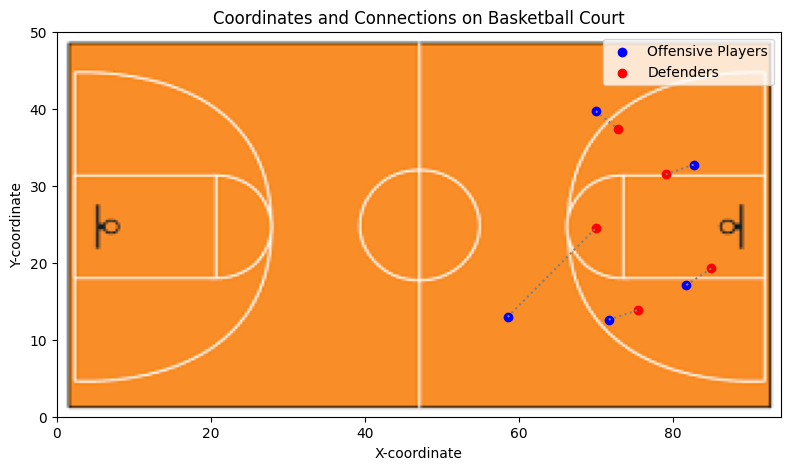

In [266]:
# Sample data
df = pd.DataFrame(def_training_data[0:5])  # Uncomment and adjust this line based on your data

# Load the images
court_image = Image.open('court_dims.png')

# Plot the basketball court
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions


# Plotting the coordinates and connecting the pairs of players with lines
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['def_x'], df['def_y'], color='red', label='Defenders')

# Connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['def_x']], [row['off_y'], row['def_y']], color='gray', linestyle='dotted')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections on Basketball Court')
plt.legend()
plt.show()


- With this play, the algorithm seems to have done a good job in assigning reponsibilities as the players are logically matched to close by and important to box out players
- In this example, the offensive player on the left block is in an advantageous rebound positioning
- The goal of the next section will be to capture these types of advantages by leveraging the player pairing coordinate data

## **Using Responsibilities to Build Features**
Now that we know which offensive player each defensive player is responsible for boxing out, there are a host of new ways to develop features based on angles (between pairs of players and the hoop) and distances (from hoop to player and player to player)

#### **Visualizing Potential Features**
- Let's dive deeper into the relative positions of the player pairings

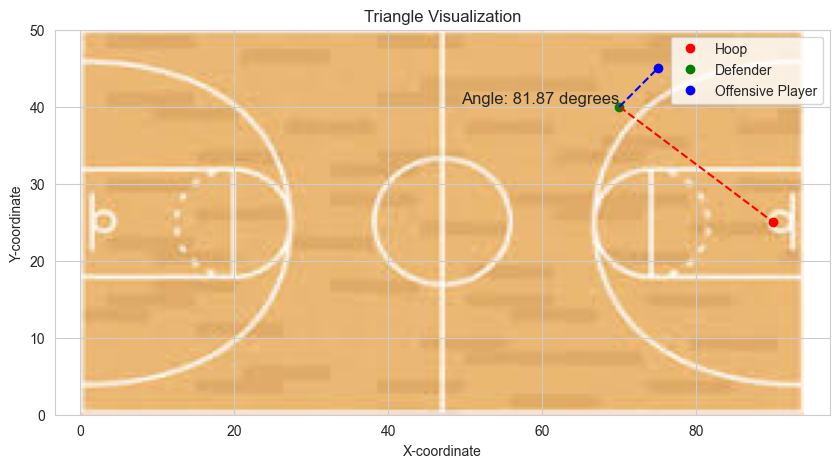

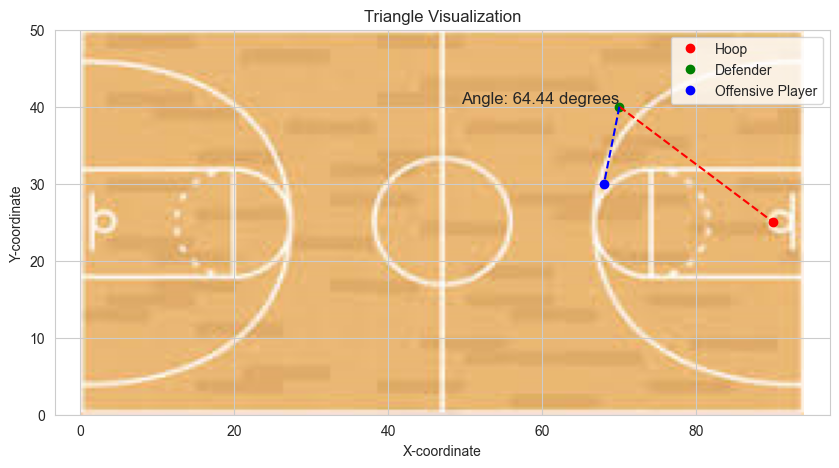

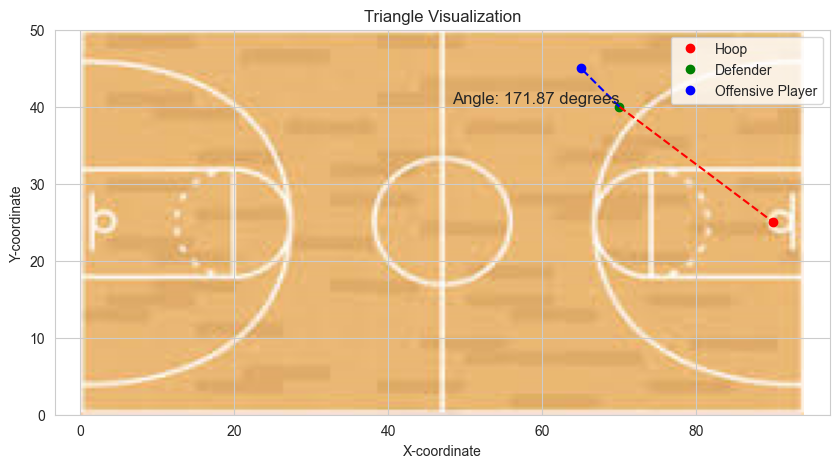

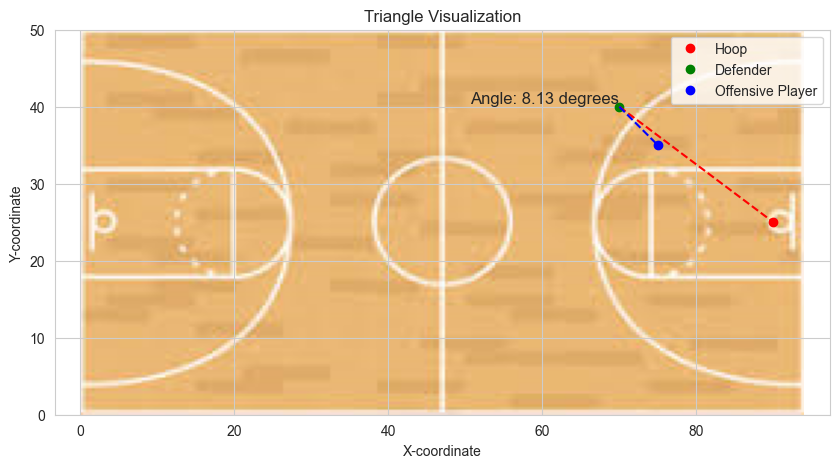

In [916]:

def calculate_angle(x1, y1, vx, vy, x2, y2):
    '''
    Calculate the angle (in degrees) formed between two points and a vertex.

    Given two points (x1, y1) and (x2, y2), this function computes the angle 
    between these two points with respect to a vertex (vx, vy). The result is 
    always an acute angle (less than or equal to 90 degrees).

    Parameters:
    - x1, y1: Coordinates of the first point.
    - vx, vy: Coordinates of the vertex.
    - x2, y2: Coordinates of the second point.

    Returns:
    - float: The acute angle (in degrees) between the two points with the vertex as the reference.
    '''
    ang = math.degrees(math.atan2(y2 - vy, x2 - vx) - math.atan2(y1 - vy, x1 - vx))
    # Adjust the angle to be between 0 and 180 degrees
    ang = abs(ang) % 360
    if ang > 180:
        return 360 - ang
    else:
        return ang


def plot_triangle(hoop, defender, offensive_player, angle):
    # Load the images
    court_image = Image.open('court_dims.png')

    # Plot the basketball court
    plt.figure(figsize=(10, 5))
    plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions
    
    # Plot hoop, defender, and offensive player
    plt.plot(hoop[0], hoop[1], 'ro', label='Hoop')
    plt.plot(defender[0], defender[1], 'go', label='Defender')
    plt.plot(offensive_player[0], offensive_player[1], 'bo', label='Offensive Player')

    # Connect lines to form the triangle
    plt.plot([defender[0], hoop[0]], [defender[1], hoop[1]], 'r--')
    plt.plot([defender[0], offensive_player[0]], [defender[1], offensive_player[1]], 'b--')

    # Add angle text
    angle_text = f'Angle: {angle:.2f} degrees'
    plt.text(defender[0], defender[1], angle_text, ha='right', va='bottom', fontsize=12)

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.title('Triangle Visualization')
    plt.axis('equal')
    plt.show()
    
# Example 1: Offensive player in front of the defender (good position for a rebound)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 45)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 2: Offensive player behind the defender (good position for the offensive player)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (68, 30)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 3: Offensive player to the left of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (65, 45)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 4: Offensive player to the right of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 35)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)


#### **Rebounding Angles and Their Implications:**

In our visual analysis, we've delineated the dynamics of offensive and defensive player positioning:

1. *Offensive Advantage with Lower Angles:*

As the angle decreases, the offensive player is in a more favorable position to secure a rebound. A lower angle signifies the offensive player is directly under the basket or positioned in a manner that gives them a clear path to the ball.

2. *Defensive Dominance with Higher Angles:*

Conversely, a higher angle hints at the defensive player's ability to successfully box out their counterpart. The greater the angle, the more likely the defensive player can impede the offensive player's path to the rebound.

3. *Feature Engineering Potential:*

Understanding these angles and their implications provides a strong foundation for crafting impactful features that can boost the model's predictive capability.

#### **Cleaning Paired Player Data**

In [268]:
# Saving a copy of the pairing data
copy_def_training_data = def_training_data.copy()
copy_def_testing_data = def_testing_data.copy()

In [841]:
# Creating binary shooter column
def_training_data['shooter'] = def_training_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
def_testing_data['shooter'] = def_testing_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
# Calculating hoop coordinates
def_training_data['hoop_x'] = def_training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_training_data['hoop_y'] = 25
def_testing_data['hoop_x'] = def_testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_testing_data['hoop_y'] = 25

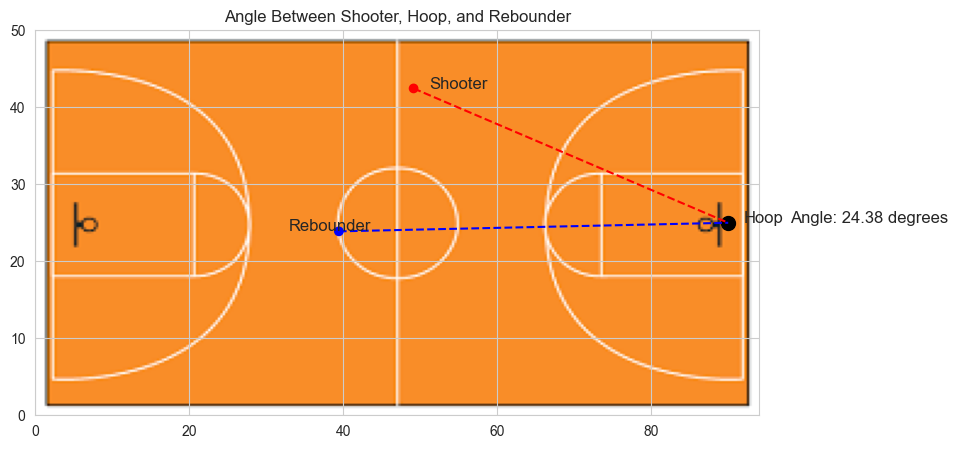

In [912]:
# Dummy data
shooter_x = np.random.rand() * 94
shooter_y = np.random.rand() * 50
rebounder_x = np.random.rand() * 94
rebounder_y = np.random.rand() * 50

hoop_y = 25  # Center of the court
hoop_x = 90 if shooter_x > 47 else 4

angle_shooter_rebounder = calculate_angle(shooter_x, shooter_y, hoop_x, hoop_y, rebounder_x, rebounder_y)

# Plotting
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions
plt.xlim(0, 94)
plt.ylim(0, 50)

# Plot positions
plt.scatter([shooter_x, rebounder_x], [shooter_y, rebounder_y], color=['red', 'blue'])
plt.scatter(hoop_x, hoop_y, color='black', s=100)

# Annotate points
plt.text(shooter_x + 2, shooter_y, 'Shooter', fontsize=12)
plt.text(rebounder_x - 6.5, rebounder_y, 'Rebounder', fontsize=12)
plt.text(hoop_x + 2, hoop_y, 'Hoop', fontsize=12)

# Draw lines to visualize the angle
plt.plot([shooter_x, hoop_x], [shooter_y, hoop_y], 'r--')
plt.plot([rebounder_x, hoop_x], [rebounder_y, hoop_y], 'b--')

# Display the angle
plt.text(hoop_x + 8, hoop_y, f'Angle: {angle_shooter_rebounder:.2f} degrees', fontsize=12)

plt.title('Angle Between Shooter, Hoop, and Rebounder')
plt.show()

In [843]:
# Distance function
def calculate_dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Function to calculate area of a triangle
def triangle_area(x1, y1, x2, y2, x3, y3):
    return 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))

def calc_dist_angle_features(the_data):
    data = the_data.copy()
    # Calculate player distances to the hoop
    data['def_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.hoop_x, x.hoop_y), axis=1)
    data['off_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.off_x, x.off_y, x.hoop_x, x.hoop_y), axis=1)

    # Distances between players
    data['distance_def_off'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # Shooter coordinates for each play
    shooter_coords = data[data['shooter'] == 1][['id', 'off_x', 'off_y']].set_index('id')

    # Calculating the distance of each defensive player to the shooter
    data['distance_def_shooter'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # Area of triangle formed by shooter, defender, and offensive player
    data['triangle_area'] = data.apply(lambda x: triangle_area(x.def_x, x.def_y, x.off_x, x.off_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # Angle between each player the basket and the shooter
    data['rebound_angle_defense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.def_x, x.def_y), axis=1)
    data['rebound_angle_offense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.off_x, x.off_y), axis=1)

    # Angle formed by the basket the defender and their assigned box out responsibility
    data['boxout_angle'] = data.apply(lambda x: calculate_angle(x.hoop_x, x.hoop_y, x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # Interaction features
    data['dist_interaction'] = data['def_distance_to_hoop'] * data['distance_def_off']

    # Feature to decide how many players are within 10 feet of the hoop
    data['def_within_10ft'] = data['def_distance_to_hoop'] < 10
    data['off_within_10ft'] = data['off_distance_to_hoop'] < 10

    # Features to help better understand where the shot is taken from
    data['shooter_angle'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, 47, 25), axis=1)
    data['corner'] = data.apply(lambda x: 1 if x['shooter_angle'] > 30 else 0, axis=1)

    # Feature to decide how many players are within 10 feet on the opposit side of the court as the shot is taken (56% of missed shots will bounce to the weak side)
    data['shooter_top_half'] = data.apply(lambda x: shooter_coords.loc[x['id'], 'off_y'] > 25, axis=1) 
    data['def_within_10ft_weakside'] = (data['def_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['def_y'] < 25, data['def_y'] > 25)
    data['off_within_10ft_weakside'] = (data['off_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['off_y'] < 25, data['off_y'] > 25)

    data['def_within_10ft_weakside'] = data['def_within_10ft_weakside'].apply(int)
    data['off_within_10ft_weakside'] = data['off_within_10ft_weakside'].apply(int)
    
    data['weakside_diff'] = data['def_within_10ft_weakside'] - data['off_within_10ft_weakside']
    data.drop(columns='shooter_top_half', inplace=True)

    # Experimenting with different boxout position calculations
    # Original feature
    data['boxout_position'] = np.log10((data['off_distance_to_hoop']**1.35) + (data['boxout_angle']))
    
    # Log transformations
    data['log_boxout_angle'] = np.log1p(data['boxout_angle'])

    # Aggregate features (we'll just demonstrate a few)
    agg_funcs = ['mean', 'min', 'max', 'std']
    # distance to hoop features already have means calculated
    agg_funcs_no_mean = ['min', 'max', 'std']
    # just sum
    sums = ['sum']

    agg_dict = {'def_distance_to_hoop': agg_funcs, 'distance_def_off': agg_funcs, 'off_distance_to_hoop': agg_funcs_no_mean, 'distance_def_shooter': agg_funcs, 'betweenness_centrality': ['mean', 'max', 'std'], 
                                        'def_within_10ft': sums, 'off_within_10ft': sums, 'def_within_10ft_weakside': sums, 'off_within_10ft_weakside': sums, 'shooter_angle': ['max'], 'corner': ['max'], 'boxout_angle': agg_funcs, 
                                        'boxout_position': agg_funcs, 'weakside_diff': sums, 'log_boxout_angle': agg_funcs}

    # Aggregate data
    aggregates = data.groupby('id').agg(agg_dict)

    # Flatten the multi-level column index
    aggregates.columns = ['_'.join(col).strip() for col in aggregates.columns.values]

    # Merge aggregate features with original data
    data = data.merge(aggregates, on='id')
    return data, agg_dict

In [844]:
def_training_data_with_feats, agg_dict_ = calc_dist_angle_features(def_training_data)
def_testing_data_with_feats, agg_dict_test = calc_dist_angle_features(def_testing_data)

In [823]:
def pivot_plays(data, agg_dict):
    # First, sort the data by 'boxout_position' for each play (id)
    # This will help reduce noise in the dataset, the most important offensive player will always be in the same column and correspond to other features
    data = data.sort_values(by=['id', 'boxout_position']).reset_index(drop=True)
    
    # Create a new column for pairing number (1,2,3,...) for each play
    data['pairing_order'] = data.groupby('id').cumcount() + 1
    
    # Extract all the feature columns
    feature_cols = [
        'betweenness_centrality', 'def_distance_to_hoop', 'boxout_angle', 'dist_interaction', 'distance_def_off', 'distance_def_shooter', 'off_distance_to_hoop',
        'rebound_angle_defense', 'rebound_angle_offense', 'triangle_area', 'boxout_position', 'log_boxout_angle'
    ]
    
    # Pivot the dataframe based on the feature columns
    pivoted_data = data.pivot_table(index='id', columns='pairing_order', values=feature_cols, aggfunc='first')

    # Flatten the multi-level column index
    pivoted_data.columns = ['_'.join(map(str, col)).strip() for col in pivoted_data.columns.values]


    agg_cols = []
    for col, funcs in agg_dict.items():
        for func in funcs:
            agg_cols.append(f"{col}_{func}")
    # Extract the aggregate columns
    aggregates = data.drop_duplicates(subset='id')[['id'] + agg_cols]

    # Merge the aggregate columns with the pivoted data
    result = pivoted_data.reset_index().merge(aggregates, on='id', how='left')
    
    return result


In [845]:
def_testing_data_with_feats

,id,def_x,def_y,annotation_code_def,offense,shooter,which_hoop,off_x,off_y,betweenness_centrality,annotation_code_off,hoop_x,hoop_y,def_distance_to_hoop,off_distance_to_hoop,distance_def_off,distance_def_shooter,triangle_area,rebound_angle_defense,rebound_angle_offense,boxout_angle,dist_interaction,def_within_10ft,off_within_10ft,shooter_angle,corner,def_within_10ft_weakside,off_within_10ft_weakside,weakside_diff,boxout_position,log_boxout_angle,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle_max,corner_max,boxout_angle_mean,boxout_angle_min,boxout_angle_max,boxout_angle_std,boxout_position_mean,boxout_position_min,boxout_position_max,boxout_position_std,weakside_diff_sum,log_boxout_angle_mean,log_boxout_angle_min,log_boxout_angle_max,log_boxout_angle_std
0,1-1,13.543482,11.221924,d1,0,0,0.0,8.901500,3.784044,0.1,t2,4,25,16.760472,21.774790,8.767557,10.746653,42.065113,19.209776,40.909716,113.323024,146.948396,False,False,36.081540,1,0,0,0,2.248786,4.739028,14.444327,7.757562,20.385939,4.963005,6.785881,3.139469,13.245158,4.205754,9.109627,25.051084,6.009726,12.744122,4.784872,22.636748,6.544418,0.06,0.2,0.089443,1,1,1,0,36.081540,1,128.863396,41.540477,176.545567,54.394955,2.220558,1.787315,2.385749,0.248084,1,4.756699,3.750456,5.179227,0.587190
1,1-1,21.022202,13.782552,d2,0,1,0.0,24.245777,10.246514,0.0,s,4,25,20.385939,25.051084,4.784872,4.784872,0.000000,2.697086,0.000000,165.737853,97.544106,False,False,36.081540,1,0,0,0,2.385749,5.116423,14.444327,7.757562,20.385939,4.963005,6.785881,3.139469,13.245158,4.205754,9.109627,25.051084,6.009726,12.744122,4.784872,22.636748,6.544418,0.06,0.2,0.089443,1,1,1,0,36.081540,1,128.863396,41.540477,176.545567,54.394955,2.220558,1.787315,2.385749,0.248084,1,4.756699,3.750456,5.179227,0.587190
2,1-1,19.343438,20.125000,d3,0,0,0.0,23.214283,19.147543,0.0,t1,4,25,16.099277,20.085814,3.992350,11.028028,16.723128,18.455167,19.141387,176.545567,64.273955,False,False,36.081540,1,0,0,0,2.369112,5.179227,14.444327,7.757562,20.385939,4.963005,6.785881,3.139469,13.245158,4.205754,9.109627,25.051084,6.009726,12.744122,4.784872,22.636748,6.544418,0.06,0.2,0.089443,1,1,1,0,36.081540,1,128.863396,41.540477,176.545567,54.394955,2.220558,1.787315,2.385749,0.248084,1,4.756699,3.750456,5.179227,0.587190
3,1-1,14.480167,20.997720,d4,0,0,0.0,13.027698,23.780991,0.0,t3,4,25,11.218385,9.109627,3.139469,14.524310,5.782268,15.180144,28.391414,41.540477,35.219771,False,True,36.081540,1,0,0,0,1.787315,3.750456,14.444327,7.757562,20.385939,4.963005,6.785881,3.139469,13.245158,4.205754,9.109627,25.051084,6.009726,12.744122,4.784872,22.636748,6.544418,0.06,0.2,0.089443,1,1,1,0,36.081540,1,128.863396,41.540477,176.545567,54.394955,2.220558,1.787315,2.385749,0.248084,1,4.756699,3.750456,5.179227,0.587190
4,1-1,10.905469,28.534722,d5,0,0,0.0,17.540733,39.998032,0.2,t4,4,25,7.757562,20.206248,13.245158,22.636748,137.135594,63.188216,84.004744,147.170059,102.750131,True,False,36.081540,1,1,0,1,2.311825,4.998361,14.444327,7.757562,20.385939,4.963005,6.785881,3.139469,13.245158,4.205754,9.109627,25.051084,6.009726,12.744122,4.784872,22.636748,6.544418,0.06,0.2,0.089443,1,1,1,0,36.081540,1,128.863396,41.540477,176.545567,54.394955,2.220558,1.787315,2.385749,0.248084,1,4.756699,3.750456,5.179227,0.587190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [895]:
def_pivoted = pivot_plays(def_training_data_with_feats, agg_dict_)
def_pivoted_test = pivot_plays(def_testing_data_with_feats, agg_dict_test)

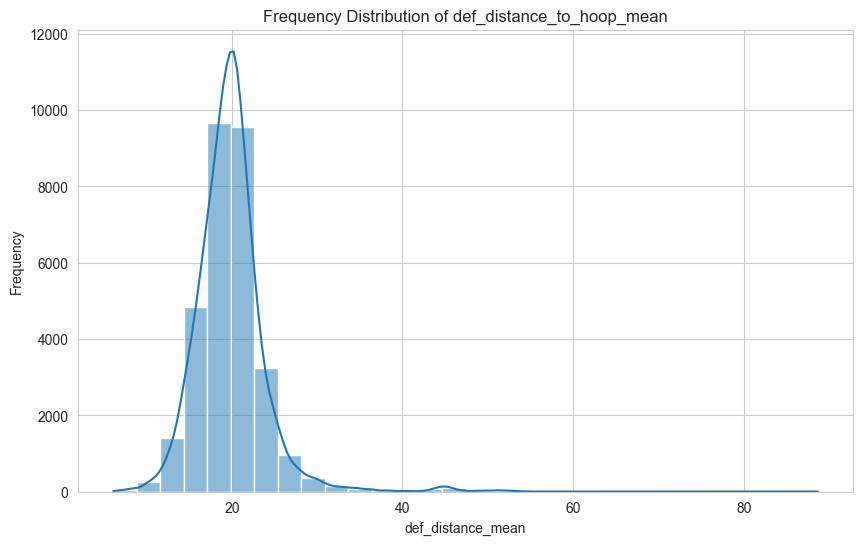

In [886]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming shot_distance_data_ is your DataFrame
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Histogram for the 'def_distance_mean' column
sns.histplot(def_pivoted['def_distance_to_hoop_max'], bins=30, kde=True)

plt.title('Frequency Distribution of def_distance_to_hoop_mean')
plt.xlabel('def_distance_mean')
plt.ylabel('Frequency')
plt.show()


Variable to help model understand outliers

In [896]:
def_pivoted['Fastbreak Probable'] = def_pivoted.apply(lambda x: 1 if x.def_distance_to_hoop_max > 25 else 0, axis=1)
def_pivoted_test['Fastbreak Probable'] = def_pivoted_test.apply(lambda x: 1 if x.def_distance_to_hoop_mean > 25 else 0, axis=1)

In [897]:
def_pivoted['Fastbreak Probable'].sum()

2066

In [898]:
# Create a StandardScaler object
scaler = StandardScaler()

# Extract the continuous features from the DataFrame
ids_train = def_pivoted[['id', 'corner_max']] # id and the one categorical feature
ids_test = def_pivoted_test[['id', 'corner_max']]

continuous_features = def_pivoted.drop(columns=['id', 'corner_max'])
continuous_features_test = def_pivoted_test.drop(columns=['id', 'corner_max'])

# Fit and transform the continuous features using the StandardScaler
scaled_continuous_features = scaler.fit_transform(continuous_features)
scaled_continuous_features_test = scaler.transform(continuous_features_test)

# Convert the scaled_continuous_features back to a DataFrame with the original column names
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

# Concatenate the scaled continuous features with the categorical features (if any)
# Use the appropriate columns indices depending on your DataFrame structure
normalized_df = pd.concat([ids_train, scaled_continuous_df], axis=1)
normalized_df_test = pd.concat([ids_test, scaled_continuous_df_test], axis=1)

In [899]:
combined_datasets_3 = normalized_df.merge(X_dist_3bins, on='id')
combined_datasets_test_3 = normalized_df_test.merge(X_test_dist_3bins, on='id')
combined_datasets_5 = normalized_df.merge(X_dist_5bins, on='id')
combined_datasets_test_5 = normalized_df_test.merge(X_test_dist_5bins, on='id')

In [900]:
X_3 = combined_datasets_3.drop(columns=['id', 'is_oreb'])
X_5 = combined_datasets_5.drop(columns=['id', 'is_oreb'])
X_3_holdout = combined_datasets_test_3.drop(columns=['id'])
X_5_holdout = combined_datasets_test_5.drop(columns=['id'])
y = combined_datasets_3['is_oreb']
holdout_ids = combined_datasets_test_3['id']

In [921]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=2, min_child_weight=5)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5789845001463537


In [869]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=2, min_child_weight=5)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_5, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5791285900861675


In [938]:
model = RandomForestClassifier(max_depth=6)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_5, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5797966188937055


In [920]:
model = RandomForestClassifier(max_depth=7)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5798827271696403


In [773]:
model = RandomForestClassifier(max_depth=8)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5798211732891827


In [671]:
model = RandomForestClassifier(max_depth=9)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5797067820721324


In [578]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

In [579]:
model.fit(X_3, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [489]:
y_pred = model.predict_proba(X_3_holdout)[:, 1]

In [939]:
# Create the XGBoost model
model = LogisticRegression()

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_5, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5797139414557421


In [940]:
# Create the XGBoost model
model = LogisticRegression()

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5796573093793105


In [1268]:
def fit_and_predict(model, X_, y_, X_holdout_):
    model.fit(X, y)
    return model.predict_proba(X_holdout)[:, 1]

In [922]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=2, min_child_weight=5)
model.fit(X_3, y)
y_pred = model.predict_proba(X_3_holdout)[:, 1]

In [369]:
X_3_holdout

,corner,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,1,-0.260812,-0.429603,1.737699,0.299076,-0.986351,0.822957,1.094941,-1.062099,0.165911,0.421110,-0.036482,-0.037408,-0.078594,0.121332,-1.278376,-0.441300,-0.552908,0.920432,-0.222102,-1.297129,0.238418,-0.146658,1.208926,-0.267040,-1.262757,0.089927,0.925676,-0.024412,-0.680933,-0.763068,-0.676706,-0.632221,0.489782,-0.640131,-1.185806,-0.449078,-0.704686,0.667932,-0.151290,-1.303248,-0.507720,-0.288126,2.542014,0.153680,-0.992016,0.314409,0.121637,-0.338985,-0.659845,0.083772,-0.246627,-0.254287,0.089927,-0.763068,-0.888593,-0.007010,0.128419,0.277993,-0.031965,-0.088707,-0.215340,-0.267545,-0.747048,-0.010323,0.247684,-0.788374,0.051681,0,0,1,0.314409,0.345581,0.685759,0.093368,0.121637,0.358439,0.089927,0.925676,-0.024412,-0.680933,-0.763068,0.020192
1,1,-0.260812,-0.429603,0.570124,-0.673893,1.580561,-0.405584,0.042694,0.213823,-0.490790,-2.666592,-0.610350,-0.680395,1.923894,0.930474,-1.278293,-0.927038,-0.825029,1.255519,1.057745,2.078346,-1.315307,-0.634298,-0.570012,-0.409240,-0.995105,-0.410601,-1.123892,0.234468,-0.234197,-0.876216,-0.702119,-0.124954,-0.743943,0.104977,1.133007,-1.084203,-0.430280,-0.719814,0.838662,1.887824,-0.737252,-0.652578,0.663183,0.205020,-0.153300,-0.527303,-1.288811,-0.756013,1.474057,-0.993214,1.518224,1.953736,-0.410601,-0.876216,0.297987,-1.296371,-1.049814,-1.642935,-1.622838,1.412727,1.292628,1.207367,0.239525,1.217470,0.247684,-0.788374,0.991606,1,0,0,-0.527303,-0.944239,-0.514682,-0.732613,-1.288811,-0.921143,-0.410601,-1.123892,0.234468,-0.234197,-0.876216,-0.656436
2,0,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.042456,-0.091312,0.601868,3.827835,-0.103026,1.181547,0.640490,-0.352577,6.801178,-0.741410,2.283074,0.807545,-0.755753,1.135576,-0.708522,0.572997,0.709489,2.107683,1.471609,-0.855927,1.143052,0.765081,0.283641,0.089630,-0.756758,-0.933979,-0.018794,1.217466,-0.024675,-1.116615,-0.099116,0.135903,0.867989,-0.657263,-1.303248,2.971626,1.694197,0.490827,0.029331,-0.992016,0.345981,3.836543,3.733235,0.880438,1.711325,0.178583,-0.534217,1.143052,-0.756758,-1.601414,1.376118,1.180037,1.343076,0.723757,-0.088707,-0.215340,-0.267

In [673]:
def create_submission(ids, preds, num_sub):
    submission = pd.DataFrame(ids)
    submission['pred'] = preds
    submission.to_csv(f'submission{num_sub}.csv', index=False)

In [923]:
create_submission(holdout_ids, y_pred, 22)

In [915]:
param_grid = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 5],
    'learning_rate': [.08]
}

# Create an instance of the XGBClassifier with a fixed learning rate and number of boosting rounds
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X_3, y)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_


In [917]:
best_params

{'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 5}

In [918]:
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score']])

                                              params  mean_test_score
0  {'learning_rate': 0.08, 'max_depth': 2, 'min_c...        -0.579675
1  {'learning_rate': 0.08, 'max_depth': 2, 'min_c...        -0.579660
2  {'learning_rate': 0.08, 'max_depth': 3, 'min_c...        -0.579812
3  {'learning_rate': 0.08, 'max_depth': 3, 'min_c...        -0.579741
4  {'learning_rate': 0.08, 'max_depth': 5, 'min_c...        -0.582064
5  {'learning_rate': 0.08, 'max_depth': 5, 'min_c...        -0.581400


In [659]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5, 6],
}

# Create an instance of the RandomForestClassifier
model = RandomForestClassifier()

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_3, y)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

print("Best hyperparameters found:")
print(best_params)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters found:
{'max_depth': 6, 'n_estimators': 100}


In [666]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune
param_grid = {
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of the RandomForestClassifier
model = RandomForestClassifier(max_depth=7, n_estimators=100)

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_3, y)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

print("Best hyperparameters found:")
print(best_params)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters found:
{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}


In [668]:
# Get mean and standard deviation of test scores for each hyperparameter combination
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Display log loss for each hyperparameter combination
for mean, std, params in zip(mean_scores, std_scores, params):
    print(f"{params} => mean log loss: {mean:.5f}, std: {std:.3f}")

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2} => mean log loss: -0.57912, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5} => mean log loss: -0.57934, std: 0.000
{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10} => mean log loss: -0.57909, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2} => mean log loss: -0.57928, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5} => mean log loss: -0.57924, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10} => mean log loss: -0.57922, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2} => mean log loss: -0.57923, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5} => mean log loss: -0.57933, std: 0.001
{'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10} => mean log loss: -0.57931, std: 0.00

In [1271]:
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score']])

                                    params  mean_test_score
0  {'max_depth': 2, 'min_child_weight': 1}        -0.580861
1  {'max_depth': 2, 'min_child_weight': 3}        -0.580910
2  {'max_depth': 2, 'min_child_weight': 5}        -0.580943
3  {'max_depth': 3, 'min_child_weight': 1}        -0.580512
4  {'max_depth': 3, 'min_child_weight': 3}        -0.580488
5  {'max_depth': 3, 'min_child_weight': 5}        -0.580755
6  {'max_depth': 5, 'min_child_weight': 1}        -0.583559
7  {'max_depth': 5, 'min_child_weight': 3}        -0.583757
8  {'max_depth': 5, 'min_child_weight': 5}        -0.583168


In [640]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)
the_model = model.fit(X_3, y)

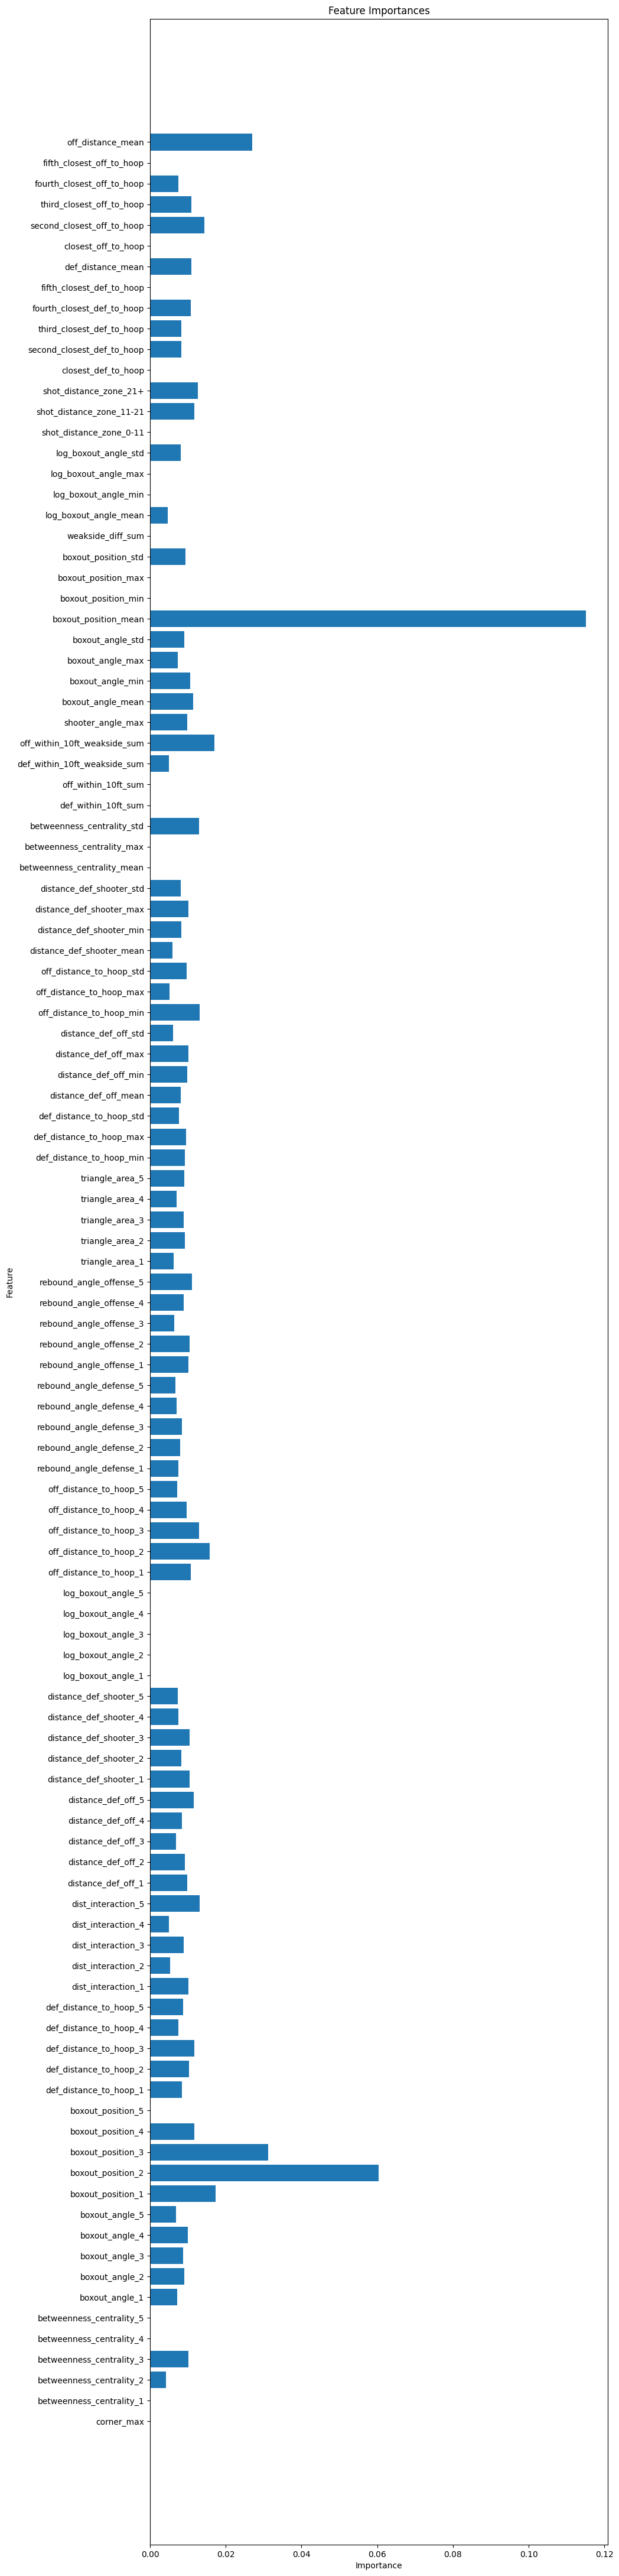

In [641]:
plot_feat_importances(X_3.columns, the_model.feature_importances_)

Notes on Features:

def_distance_to_hoop & off_distance_to_hoop: These represent how close each player is to the hoop. Players closer to the hoop might have a better chance of getting a rebound.

distance_def_off: Indicates how well a defender is covering an offensive player.

triangle_area: Larger areas might suggest that an offensive player has more space, thus a higher chance to get a rebound.

shooting_angle & relative_angle: These can help in understanding the shooting dynamics. The angle might tell if it was a difficult shot, and the relative angle can tell how well the players are positioned relative to the shot.

dist_interaction: Multiplicative interaction between a defender's distance to the hoop and the offensive player. It encapsulates both player's spatial relevance in relation to the play's outcome.

Aggregate features: These give a holistic view of the defense team's positioning in relation to the hoop and the offensive players.

In [368]:
pd.set_option('display.max_columns', None)

# Using Baruta algorithm for feature selection

In [381]:
# Define the XGBoost model with your architecture
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)
np.bool = bool
# Convert X and y to numpy arrays (if they aren't already)
X_np = np.array(X_5)
y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

# Initialize Boruta
boruta_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta
boruta_selector.fit(X_np, y_np)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	85
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	61
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	61
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	61
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	61
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	13
Rejected: 	65
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	13
Rejected: 	65
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	13
Rejected: 	65
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	13
Rejected: 	65
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	10
Reject

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False,
                                 eval_metric='logloss', feature_types=None,
                                 gamma=None, gpu_id=None, grow_policy=None,
                                 importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=0.1, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=3,
                                 max_leaves=None, min_child_weight=5,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=176, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=1113392132, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1B3808B8F40, verbose=2)

In [384]:
# Check selected features
selected_features = X_5.columns[boruta_selector.support_]
print('Selected Features:')
print(selected_features)

# Optionally, you can also get features that Boruta is unsure about
tentative_features = X_5.columns[boruta_selector.support_weak_]
print('\nTentative (Unsure) Features:')
print(tentative_features)

Selected Features:
Index(['off_distance_to_hoop_1', 'off_distance_to_hoop_2',
       'off_distance_to_hoop_3', 'def_distance_to_hoop_max',
       'off_distance_to_hoop_std', 'betweenness_centrality_std',
       'off_within_10ft_weakside_sum', 'shot_distance_zone_11-17',
       'shot_distance_zone_21+', 'off_distance_mean'],
      dtype='object')

Tentative (Unsure) Features:
Index(['betweenness_centrality_2', 'dist_interaction_3', 'distance_def_off_5',
       'fourth_closest_def_to_hoop'],
      dtype='object')


In [386]:
# Define the XGBoost model with your architecture
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)

# Convert X and y to numpy arrays (if they aren't already)
X_np = np.array(X_5[selected_features])
y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

# Select the important features
X_filtered = X_np.copy()

# Perform cross-validation using the selected features
cross_val_scores = cross_val_score(model, X_filtered, y_np, cv=5, scoring='neg_log_loss')

# Convert negative log loss values to positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss after Boruta feature selection:', log_loss_scores.mean())


Average Log Loss after Boruta feature selection: 0.5819743619520344


# Experimenting with oversampling to see if adding more examples of offensive rebounds helps improve performance

In [732]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Splitting and cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)
log_loss_scores = []

# Performing cross-validation and oversampling within each fold
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Apply SMOTE to the training data only
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    model.fit(X_res, y_res)
    predictions = model.predict_proba(X_test)[:, 1]  # probabilities of the positive class
    score = log_loss(y_test, predictions)
    log_loss_scores.append(score)

# Convert the list of log loss scores to a numpy array
log_loss_scores = np.array(log_loss_scores)

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.6575956446462099


# Experimenting with a Dense Neural Net

In [1031]:
X

,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,0.000000,0.000000,0.142857,0.000,0.2,0.117258,0.182028,0.162660,0.189733,0.097786,0.006449,0.031517,0.057750,0.040807,0.117903,0.043755,0.056008,0.255989,0.192511,0.280897,0.545915,0.334336,0.318963,0.171041,0.196029,0.217322,0.199911,0.264918,0.267149,0.235529,0.340915,0.083163,0.439972,0.149713,0.055903,0.397414,0.061658,0.433699,0.233765,0.000000,0.050191,0.001423,0.252881,0.161048,0.000000,0.114437,0.130584,0.121996,0.054626,0.341992,0.137597,0.255782,0.268695,0.228612,0.217322,0.235529,0.174614,0.332695,0.403680,0.293516,0.137556,0.3,0.2,0.200000,0.2,0.0,0.25,0.00,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649
1,0.000000,0.000000,0.142857,0.000,0.1,0.053770,0.040240,0.117312,0.180680,0.177425,0.002825,0.050783,0.057876,0.028414,0.103345,0.042035,0.421505,0.357219,0.141074,0.145039,0.040723,0.037341,0.118792,0.142402,0.149472,0.085096,0.241874,0.235381,0.240464,0.223225,0.148041,0.140863,0.419871,0.094955,0.085424,0.000000,0.269805,0.534822,0.096030,0.065969,0.000000,0.036078,0.042713,0.009517,0.030699,0.079004,0.042238,0.125965,0.135199,0.402492,0.132198,0.231079,0.214168,0.202523,0.085096,0.223225,0.213362,0.111404,0.048630,0.110738,0.117656,0.2,0.1,0.122474,0.4,0.2,0.25,0.00,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633
2,0.000000,0.000000,0.428571,0.000,0.1,0.072127,0.170405,0.154108,0.145552,0.257576,0.007618,0.152672,0.058501,0.037600,0.097973,0.088526,0.310094,0.274126,0.230324,0.094962,0.545759,0.312835,0.195829,0.267564,0.067133,0.188306,0.244887,0.246203,0.239805,0.223942,0.346906,0.018962,0.222324,0.321365,0.074813,0.440837,0.227749,0.304330,0.447667,0.000000,0.149497,0.187137,0.165384,0.219531,0.000000,0.125772,0.080325,0.204530,0.135523,0.374257,0.278158,0.187210,0.157620,0.220057,0.188306,0.223942,0.159805,0.277366,0.170372,0.240418,0.158181,0.4,0.3,0.291548,0.2,0.2,0.25,0.25,0,0,1,0.094578,-0.243006,0.581200,-0.134121,-0.556947,0.736766,0.061919,0.558299,0.310714,-0.288736,-0.718246
3,0.000000,0.000000,0.142857,0.250,0.0,0.0730

In [776]:
# For building the neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# For cross-validation
from sklearn.model_selection import cross_val_score

# Define the neural network model
def create_neural_net():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_3.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the scikit-learn compatible Keras classifier
model = KerasClassifier(build_fn=create_neural_net, epochs=10, batch_size=32, verbose=0)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_3, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


193/193 [==============================] - 0s 896us/step
Average Log Loss: 0.5816142396375523


In [1280]:
# Modify the create_neural_net function to accept hyperparameters
def create_neural_net(n_layers=1, first_layer_units=64, dropout_rate=0.5):
    model = Sequential()
    
    # Input layer
    model.add(Dense(first_layer_units, activation='relu', input_dim=X.shape[1]))
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(n_layers - 1):
        model.add(Dense(first_layer_units // (2**(_ + 1)), activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_neural_net, epochs=10, batch_size=32, verbose=0)

# Define hyperparameters and their possible values
param_grid = {
    'n_layers': [2, 3],
    'first_layer_units': [64, 128],
    'epochs': [10, 20],
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_result = grid.fit(X, y)

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


193/193 [==============================] - 0s 1ms/step
Best: -0.580712 using {'epochs': 10, 'first_layer_units': 128, 'n_layers': 2}


In [724]:
cross_val_scores

array([-0.58020099, -0.59627271, -0.59107032, -0.57531982, -0.57744141])

# Creating Separate Models for different shot distances
- The dynamics of a play differ on shots of different distances because it is better to be positioned in different areas of the floor depending on shot distance
- In an attempt to reduce noise in the model features, I will create five separate models: one for data from 0-7 ft, 7-11 ft, 11-17 ft, 17-21 ft, 21+ ft
- By focusing on a specific shot distance range, each model might better learn the unique characteristics and interactions of a play for that range

In [924]:
all_necessary_data = combined_datasets_3.copy()
all_necessary_data_test = combined_datasets_test_3.copy()

In [925]:
def assign_shot_range(row):
    if (row['shot_distance_zone_0-11'] == 1):
        return '0-11'
    elif (row['shot_distance_zone_11-21'] == 1):
        return '11-21'
    else: 
        return '21+'

def create_shot_range_column(data):
    data['shot_range'] = data.apply(assign_shot_range, axis=1)
    return data

# Use the function
shot_distance_data_ = create_shot_range_column(all_necessary_data)
shot_distance_data_test = create_shot_range_column(all_necessary_data_test)


In [926]:
# Define the distance ranges and their corresponding columns
shot_distance_ranges = ['0-11', '11-21', '21+']

# Train and evaluate models
def evaluate_model(X, y, classifier_):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    classifier = classifier_
    log_losses = []
    
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_val)
        loss = log_loss(y_val, preds)
        log_losses.append(loss)
    
    return np.mean(log_losses)

In [927]:
def try_diff_models(classifiers, the_data):
    results = {}

    # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in the_data.columns if col not in exclude_columns]
    i = 0
    for shot_range in the_data['shot_range'].unique():
        data_range = the_data.loc[the_data['shot_range'] == shot_range]
        
        X = data_range[X_columns]
        y = data_range['is_oreb']
        loss = evaluate_model(X, y, classifiers[i])
        results[shot_range] = loss
        i += 1

    return results

In [646]:
models = {'Log Reg': LogisticRegression(), 'RFC': RandomForestClassifier(max_depth=3), 'XGB': xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)}
results_dict = {}
for m in models.keys():
    results_dict[m] = try_diff_models([models[m]] * 5, shot_distance_data_)

In [647]:
pd.DataFrame(results_dict)

,Log Reg,RFC,XGB
21+,0.569265,0.567686,0.569741
0-11,0.610492,0.613780,0.612603
11-21,0.559236,0.553109,0.559794


In [648]:
def experimenting_with_models_for_diff_distances(classifiers, the_data):
    combined_log_losses = []

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

     # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in the_data.columns if col not in exclude_columns]
    
    for train_index, val_index in cv.split(the_data):
        
        combined_preds = []
        combined_true = []

        i = 0 
        for shot_range in the_data['shot_range'].unique():
            data_range_train = the_data.iloc[train_index][the_data['shot_range'] == shot_range]
            data_range_val = the_data.iloc[val_index][the_data['shot_range'] == shot_range]

            target_vals_train = data_range_train['is_oreb']
            target_vals_val = data_range_val['is_oreb']

            X_train = data_range_train[X_columns]
            y_train = target_vals_train
            
            X_val = data_range_val[X_columns]
            y_val = target_vals_val
            
            classifier = classifiers[i]
            classifier.fit(X_train, y_train)
            preds = classifier.predict_proba(X_val)[:, 1]
            
            combined_preds.extend(preds)
            combined_true.extend(y_val)
            i += 1

        # Calculate the log loss for this fold using the combined predictions and actual values
        fold_loss = log_loss(combined_true, combined_preds)
        print(fold_loss)
        combined_log_losses.append(fold_loss)

    combined_loss = np.mean(combined_log_losses)
    print(f'Combined Log Loss: {combined_loss}')


In [649]:
experimenting_with_models_for_diff_distances([LogisticRegression(), RandomForestClassifier(max_depth=3), LogisticRegression()], shot_distance_data_)

0.57353344747351
0.5905766353679659
0.5836817555197327
0.5844353929389579
0.5712238623894302
Combined Log Loss: 0.5806902187379193


In [652]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=3)] * 3, shot_distance_data_)

0.5722415073936764
0.5906179075044005
0.5827272508205034
0.5810931530248549
0.5710366858282906
Combined Log Loss: 0.5795433009143451


In [653]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=2)] * 3, shot_distance_data_)

0.573660085626783
0.5921179100913572
0.5834529864970305
0.5818239759258677
0.5717730443907885
Combined Log Loss: 0.5805656005063653


In [931]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=4)] * 3, shot_distance_data_)

0.5712545808440387
0.5900337656498721
0.5824467124495294
0.5803668389902197
0.5703333680411184
Combined Log Loss: 0.5788870531949556


In [932]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=5)] * 3, shot_distance_data_)

0.5711914824078752
0.5898557731781935
0.5824684422686763
0.5804633154225266
0.5708646090798822
Combined Log Loss: 0.5789687244714308


In [928]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=6)] * 3, shot_distance_data_)

0.5714180433471238
0.5895562107130887
0.5819344102825378
0.5804927277379109
0.5703682737744261
Combined Log Loss: 0.5787539331710174


In [657]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=7)] * 3, shot_distance_data_)

0.5719838868109306
0.589693826336863
0.5823537259032083
0.5809843772810714
0.5703387837945028
Combined Log Loss: 0.5790709200253152


In [780]:
experimenting_with_models_for_diff_distances([LogisticRegression()] * 3, shot_distance_data_)

0.5730440850254543
0.5867709937651812
0.583163204211231
0.584723334103615
0.5703608917146187
Combined Log Loss: 0.5796125017640199


In [929]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=1, min_child_weight=3)
experimenting_with_models_for_diff_distances([xgb_model] * 3, shot_distance_data_)

0.5720525077036474
0.5896386204550715
0.5814126054278956
0.5816011126623599
0.570453324139267
Combined Log Loss: 0.5790316340776483


In [930]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=2, min_child_weight=3)
experimenting_with_models_for_diff_distances([xgb_model] * 3, shot_distance_data_)

0.5717456171252383
0.5886183140579209
0.5821573051130795
0.5818435334711151
0.5707827334675556
Combined Log Loss: 0.5790295006469819


In [388]:
def predicting_with_models_for_diff_distances(classifiers, train_data, test_data):
    # Lists to store IDs and predictions
    combined_ids = []
    combined_preds = []
    
    # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in train_data.columns if col not in exclude_columns]
    
    i = 0 
    for shot_range in train_data['shot_range'].unique():
        # Split data based on shot range for training and testing
        data_range_train = train_data[train_data['shot_range'] == shot_range]
        data_range_test = test_data[test_data['shot_range'] == shot_range]

        # Get target values for training
        target_vals_train = data_range_train['is_oreb']
        
        X_train = data_range_train[X_columns]
        y_train = target_vals_train

        X_test = data_range_test[X_columns]

        classifier = classifiers[i]
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_test)[:, 1]

        combined_preds.extend(preds)
        combined_ids.extend(data_range_test['id'].values)
        
        i += 1

    # Compile results into a dataframe and return
    result_df = pd.DataFrame({
        'id': combined_ids,
        'pred': combined_preds
    })

    return result_df

In [935]:
submission24 = predicting_with_models_for_diff_distances([RandomForestClassifier(max_depth=6)] * 3, shot_distance_data_, shot_distance_data_test)

In [937]:
submission24.to_csv(f'submission24.csv', index=False)

In [391]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)

In [392]:
submission15 = predicting_with_models_for_diff_distances([xgb_model] * 3, shot_distance_data_, shot_distance_data_test)

In [396]:
submission15.to_csv(f'submission15.csv', index=False)

In [397]:
experimenting_with_models_for_diff_distances([xgb_model, xgb_model, xgb_model], shot_distance_data_)

0.5740038269099553
0.5923366298542558
0.5852101152782501
0.5861828633512244
0.5742771423730093
Combined Log Loss: 0.582402115553339


In [918]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=1), RandomForestClassifier(max_depth=1), RandomForestClassifier(max_depth=1)], shot_distance_data_)

0.5802522514454196
0.5978763316831841
0.5873278717238224
0.5865401279493971
0.5770980081630714
Combined Log Loss: 0.5858189181929789


# CNNs
- Representing the player positions on the court
- This approach is suitable for preparing the data to be used in a CNN

In [233]:
def create_court_grid(court_width, court_height):
    '''
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or centimeters.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or centimeters.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Examples
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    '''
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    '''
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    '''
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [234]:
# Define the dimensions of the court grid with high resolution
# Depending on runtime, using lower resolution images may be a better approach here, but let's start with inches

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# Derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [235]:
# Derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

In [ ]:
# Create image-like training examples with higher resolution and multiple channels
X_train_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    print
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_train_images.append(court_grid)

In [81]:
# Create image-like training examples with higher resolution and multiple channels
X_test_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_test.reshape(-1, 10, 2), shooter_indices_test.reshape(-1, 10), offense_indices_test.reshape(-1, 10), defense_indices_test.reshape(-1, 10), which_hoop_test.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_test_images.append(court_grid)

In [82]:
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)

In [240]:
training_data[21:30]

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
21,2-4,84.217896,20.089925,d2,0,0,1.0,90,25,0
22,2-4,65.491561,13.006945,d3,0,0,1.0,90,25,0
23,2-4,64.886192,24.660033,d4,0,0,1.0,90,25,0
24,2-4,83.131249,30.256944,d5,0,0,1.0,90,25,0
25,2-4,87.963438,3.638889,s,1,1,1.0,90,25,0
26,2-4,67.181831,9.807129,t1,1,0,1.0,90,25,0
27,2-4,85.305260,28.430379,t2,1,0,1.0,90,25,0
28,2-4,69.115013,38.484702,t3,1,0,1.0,90,25,0
29,2-4,55.824547,24.888578,t4,1,0,1.0,90,25,0


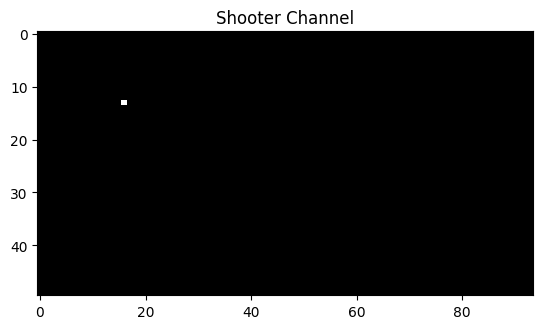

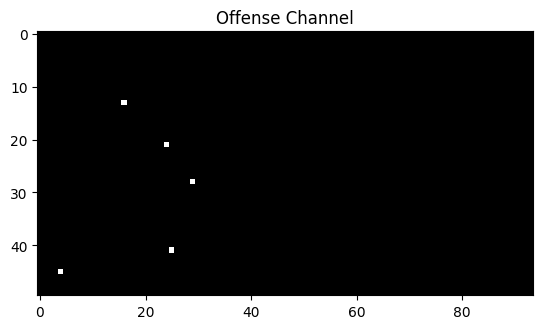

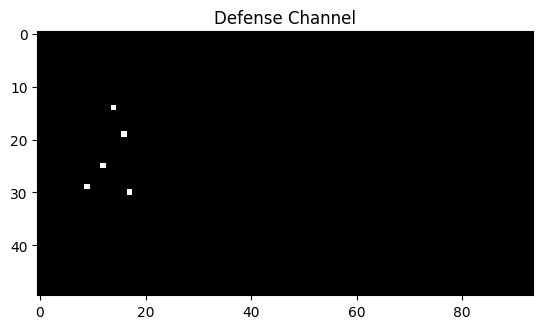

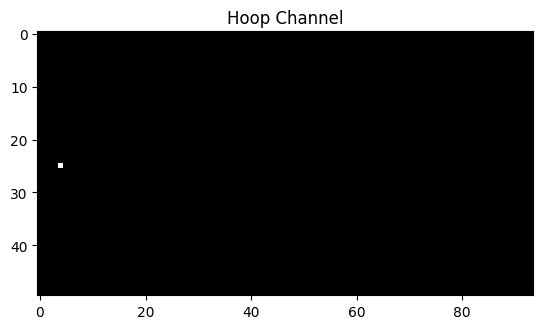

In [238]:
sample_index = 1
# Visualize the shooter channel
plt.imshow(X_train_images[sample_index, :, :, 0], cmap='gray')
plt.title('Shooter Channel')
plt.show()

# Visualize the offense channel
plt.imshow(X_train_images[sample_index, :, :, 1], cmap='gray')
plt.title('Offense Channel')
plt.show()

# Visualize the defense channel
plt.imshow(X_train_images[sample_index, :, :, 2], cmap='gray')
plt.title('Defense Channel')
plt.show()

# Visualize the basketball hoop channel
plt.imshow(X_train_images[sample_index, :, :, 3], cmap='gray')
plt.title('Hoop Channel')
plt.show()


In [61]:
y_train = train_pbp['is_oreb']

In [34]:
# Define the file path for saving the data
save_path = 'X_train_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_train_images=X_train_images)

In [85]:
# Define the file path for saving the data
save_path = 'X_test_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_test_images=X_test_images)

In [200]:
# Load the data from the file
save_path = 'X_train_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [221]:
# Load the data from the file
save_path = 'X_test_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_test_images = loaded_data['X_test_images']

In [222]:
testing_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y
0,1-1,13.543482,11.221924,d1,0,0,0.0,4,25
1,1-1,21.022202,13.782552,d2,0,0,0.0,4,25
2,1-1,19.343438,20.125000,d3,0,0,0.0,4,25
3,1-1,14.480167,20.997720,d4,0,0,0.0,4,25
4,1-1,10.905469,28.534722,d5,0,0,0.0,4,25
...,...,...,...,...,...,...,...,...,...
132015,5020-51,86.635907,25.581666,s,1,1,1.0,90,25
132016,5020-51,74.298406,41.692778,t1,1,0,1.0,90,25
132017,5020-51,79.953092,19.470556,t2,1,0,1.0,90,25
132018,5020-51,56.526532,34.748334,t3,1,0,1.0,90,25


Regular CNN

In [202]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [204]:
X_train.shape

(24644, 50, 94, 4)

In [16]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model with log loss (binary cross-entropy)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Epoch 1/10
771/771 [==============================] - 172s 221ms/step - loss: 0.6158 - accuracy: 0.7177 - val_loss: 0.6030 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 170s 220ms/step - loss: 0.5956 - accuracy: 0.7182 - val_loss: 0.5974 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 172s 223ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 169s 220ms/step - loss: 0.5909 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 169s 219ms/step - loss: 0.5898 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 180s 233ms/step - loss: 0.5891 - accuracy: 0.7182 - val_loss: 0.5943 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 180s 234ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5920 -

In [65]:
shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
shooter_data_test['mean_def_dist'] = def_mean_distances_test.values

In [66]:
cnn_train_data = shooter_data_train[['mean_def_dist', 'distance_from_hoop']]
cnn_test_data = shooter_data_test[['mean_def_dist', 'distance_from_hoop']]

In [246]:
cnn_train_data = train_pbp[['id']].merge(final, on='id')
cnn_test_data = test_pbp[['id']].merge(final_test, on='id')

In [248]:
cnn_train_data

,id,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,distance_def_hoop_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,is_oreb
0,2-2,-0.710082,-0.155181,-0.009355,-0.760539,-0.613744,1.050888,-0.011034,1.311676,0.967921,-1.147547,-0.435967,-0.774311,1.458459,-1.071467,-1.332522,0.835685,-0.857042,1.786462,0.287726,-1.567406,0,0,0,0,1,0,0,0.786057,0.280024,0.707359,1.194021,0.876404,0.314668,0.394397,-0.562562,0.385818,0.156934,1.509469,0
1,2-3,-0.569330,-0.093100,-0.603504,-0.211011,2.167174,0.210992,0.129626,-0.566833,0.406687,-1.266572,-0.783079,0.185376,1.597885,0.863236,1.782947,-0.010758,0.319237,0.852176,0.934847,-0.187128,0,0,0,1,0,0,0,-0.331162,0.090078,-0.208605,0.106853,-0.320979,-1.069568,1.759438,1.021993,0.090994,0.426478,-0.133723,0
2,2-4,-0.473297,2.623307,-0.555371,-0.899023,-0.646416,0.537576,-0.822003,2.536463,2.129377,-0.970497,-0.302506,0.116337,-0.971158,-0.034553,1.659502,0.446920,-1.418921,1.044797,1.756071,0.444008,0,0,0,0,1,0,0,1.140872,0.266573,-0.283265,1.035903,2.081879,1.751264,-0.564888,1.161601,0.967612,0.875227,1.641669,0
3,2-6,0.243318,-0.858862,0.923694,-0.248863,-0.743675,-0.798269,-0.868624,-1.043288,0.453333,-0.014825,2.994300,-0.981645,1.775331,0.398497,-0.087371,0.775403,-0.926239,0.419199,0.688205,0.182039,0,1,0,0,0,0,0,-0.815777,-0.135552,-0.615646,-1.108279,-0.532263,-1.081331,0.276258,1.277569,0.594756,0.013457,-0.666933,1
4,2-8,-0.702092,-0.594138,0.344691,-0.858299,-0.259593,0.904599,1.159334,0.100688,2.225824,-0.089156,-0.286721,-0.161109,0.410532,-0.997944,-0.218650,0.782093,0.996062,0.227255,1.245879,-0.045698,0,0,0,0,1,0,0,1.490940,1.744373,0.954359,1.599550,0.907740,1.372389,2.355850,1.184354,0.858583,0.640402,0.538693,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,-0.723257,-0.612455,2.104411,0.193173,-0.848141,0.840003,0.849411,-1.125310,0.976224,0.489659,-0.415840,-0.878684,-0.075693,-0.226359,-1.714821,0.674205,0.314704,-1.156605,0.132689,-0.391487,0,0,0,0,1,0,0,0.730092,-0.270340,1.767161,1.150276,0.473428,-0.032891,0.034464,0.787390,0.082692,-0.933698,-1.193436,0
30801,5020-47,-0.536922,-0.865885,0.004109,-0.041480,-0.920753,1.732166,1.199104,-0.797361,-0.927438,0.138796,0.056853,-0.588074,1.089855,-0.488884,-0.913890,1.572539,0.826123,0.309634,-0.786144,-0.189932,0,0,0,0,0,0,1,0.573799,0.159317,-0.541952,0.435837,0.941039,1.437487,0.926948,1.018774,0.189037,0.237462,0.848327,1
30802,5020-48,1.403944,-0.500133,-0.316116,-0.923838,-0.710730,-1.133378,-0.225646,0.339893,0.327264,3.507915,-0.147355,-0.588338,-0.079992,-1.562943,-0.692989,-1.110869,-0.267781,0.351160,-0.831736,0.930494,0,1,0,0,0,0,0,0.820408,-0.185151,0.376278,0.274286,-0.431760,3.417283,-0.125905,-0.301630,-0.984067,-0.740732,0.042623,1
30803,5020-49,-0.154329,-0.193381,-0.883290,-0.882901,-0.517252,1.272319,0.186722,0.096636,1.019928,-0.344019,0.781682,-0.122855,0.613651,-1.314112,0.251586,1.398365,0.191432,0.723119,0.200607,0.090904,0,0,0,0,0,1,0,0.815505,1.562343,0.750784,0.189621,0.534388,0.679611,2.184439,1.154394,0.465046,0.125817,0.452461,1


In [250]:
cnn_train_data.drop(columns=['id', 'is_oreb'], inplace=True)
cnn_test_data.drop(columns=['id'], inplace=True)

In [254]:
# Split the data into training and validation sets
X_train_img, X_val_img, y_tr, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)
X_train_, X_val_, _, _ = train_test_split(cnn_train_data, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [255]:
# Print the shapes of input data
print('Shape of X_train_img:', X_train_img.shape)
print('Shape of X_train_:', X_train_.shape)
print('Shape of X_val_img:', X_val_img.shape)
print('Shape of X_val_:', X_val_.shape)
print('Shape of y_tr:', y_tr.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train_img: (24644, 50, 94, 4)
Shape of X_train_: (24644, 38)
Shape of X_val_img: (6161, 50, 94, 4)
Shape of X_val_: (6161, 38)
Shape of y_tr: (24644,)
Shape of y_val: (6161,)


Model Architecture:

- CNN Model for Image Data:
    - Input shape: (court_height, court_width, 4) (Assuming 4 channels for the image data)
    - Conv2D Layers: 3 layers with 32, 64, and 128 filters and 'relu' activation
    - MaxPooling2D Layers: Applied after each Conv2D layer with (2, 2) pool size
    - Flatten Layer: Flattens the output of the last MaxPooling2D layer
    - Dense Layer: 256 neurons with 'relu' activation and L2 regularization (lambda = 0.01)
    - Dropout Layer: Dropout rate of 0.5 applied after the Dense layer
- Input Layer for Rebound Percentage Features:
    - Input shape: (2,)
- Concatenation:
    - Concatenates the outputs from the two branches (CNN model and rebound percentage features)
- Output Layer:
    - Dense layer with 1 neuron and 'sigmoid' activation
Model Performance:

Epochs: 10
Batch Size: 32
Training Time: Approximately 10 minutes per epoch
Validation Log Loss: 0.5925
Validation Accuracy: 0.7174

In [126]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f'Validation Log Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Epoch 1/10
771/771 [==============================] - 62s 79ms/step - loss: 0.6307 - accuracy: 0.7166 - val_loss: 0.6024 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 64s 83ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5973 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 65s 84ms/step - loss: 0.5964 - accuracy: 0.7182 - val_loss: 0.5977 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 70s 91ms/step - loss: 0.5950 - accuracy: 0.7182 - val_loss: 0.5953 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5932 - accuracy: 0.7182 - val_loss: 0.5956 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5927 - accuracy: 0.7182 - val_loss: 0.5937 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 80s 104ms/step - loss: 0.5888 - accuracy: 0.7182 - val_loss: 0.5917 - val_accuracy

Best model to this point

In [82]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 8

history = model.fit([X_train_images, normalized_df], y_train_official, batch_size=batch_size, epochs=epochs)

Epoch 1/8
963/963 [==============================] - 102s 105ms/step - loss: 0.6399 - accuracy: 0.7048
Epoch 2/8
963/963 [==============================] - 107s 111ms/step - loss: 0.6005 - accuracy: 0.7180
Epoch 3/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5956 - accuracy: 0.7181
Epoch 4/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5911 - accuracy: 0.7180
Epoch 5/8
963/963 [==============================] - 103s 107ms/step - loss: 0.5892 - accuracy: 0.7180
Epoch 6/8
963/963 [==============================] - 97s 100ms/step - loss: 0.5876 - accuracy: 0.7180
Epoch 7/8
963/963 [==============================] - 74s 77ms/step - loss: 0.5859 - accuracy: 0.7181
Epoch 8/8
963/963 [==============================] - 86s 89ms/step - loss: 0.5857 - accuracy: 0.7181


In [79]:
y_train_official = train_pbp['is_oreb']

In [90]:
# Evaluate the model on the validation set
test_predictions = model.predict([X_test_images, np.array(normalized_df_test)])

test_predictions_flattened = test_predictions.flatten()

413/413 [==============================] - 10s 24ms/step


In [134]:
# Define the CNN model as a function
def create_model(learning_rate=0.001, dropout_rate=0.5, dense_units=128, include_last_conv_layer=True):
    input_img = Input(shape=(court_height, court_width, 4))
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    if include_last_conv_layer:
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    
    model = Model(inputs=[input_img], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create KerasClassifier wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for the randomized search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'dense_units': [64, 128, 256],
    'include_last_conv_layer': [True, False]
}

# Define log loss as the scoring metric
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring=log_loss_scorer, n_iter=5, cv=3, verbose=3)

random_search_results = random_search.fit(X_train_img, y_tr)

# Print the best hyperparameters and log loss score
print("Best Hyperparameters:", random_search_results.best_params_)
print("Best Log Loss:", -random_search_results.best_score_)


C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3079426148.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
257/257 [==============================] - 6s 22ms/step
[CV 1/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.591 total time=  49.5s
257/257 [==============================] - 6s 22ms/step
[CV 2/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.596 total time=  53.2s
257/257 [==============================] - 6s 24ms/step
[CV 3/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.598 total time=  52.8s
257/257 [==============================] - 6s 23ms/step
[CV 1/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.592 total time=  56.8s
257/257 [==============================] - 5s 20ms/step
[CV 2/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.596 total time=  55.5s
257/257 

In [168]:
val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Log Loss: 0.5820042970390139
Validation Accuracy: 0.7175783152085701


# GNNs

In [ ]:
training_data['hoop_x'] = training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
training_data['hoop_y'] = 25

In [ ]:
testing_data['hoop_x'] = testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
testing_data['hoop_y'] = 25

In [ ]:
training_data = training_data.merge(train_pbp[['id', 'is_oreb']], on='id', how='left')

In [ ]:
graph_training = training_data.copy()

In [ ]:
graph_testing = testing_data.copy()

In [ ]:
graph_scaler = MinMaxScaler()
normalized_coords = pd.DataFrame()
normalized_coords_test = pd.DataFrame()

normalized_coords[['court_x', 'court_y']] = graph_scaler.fit_transform(graph_training[['court_x', 'court_y']].values)
print(graph_scaler.data_max_)
normalized_coords[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_training[['hoop_x', 'hoop_y']])
normalized_coords_test[['court_x', 'court_y']] = graph_scaler.transform(graph_testing[['court_x', 'court_y']])
normalized_coords_test[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_testing[['hoop_x', 'hoop_y']])

[93.92655974 50.        ]


In [ ]:
graph_training[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords
graph_testing[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords_test

In [ ]:
graph_training[graph_training.id == '2889-4']

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
126000,2889-4,0.897775,0.415919,d1,0,0,1.0,0.958193,0.489998,0
126001,2889-4,0.984597,0.530090,d2,0,0,1.0,0.958193,0.489998,0
126002,2889-4,1.000000,0.486882,d3,0,0,1.0,0.958193,0.489998,0
126003,2889-4,0.783638,0.536293,d4,0,0,1.0,0.958193,0.489998,0
126004,2889-4,0.897775,0.289370,d5,0,0,1.0,0.958193,0.489998,0
126005,2889-4,0.913107,0.468390,s,1,1,1.0,0.958193,0.489998,0
126006,2889-4,0.909700,0.520861,t1,1,0,1.0,0.958193,0.489998,0
126007,2889-4,0.875629,0.184429,t2,1,0,1.0,0.958193,0.489998,0
126008,2889-4,0.713792,0.591852,t3,1,0,1.0,0.958193,0.489998,0
126009,2889-4,0.897775,0.727659,t4,1,0,1.0,0.958193,0.489998,0


In [ ]:
graph_training[:20]

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
0,2-2,0.775145,0.743156,d1,0,0,1.0,0.958193,0.489998,0
1,2-2,0.841934,0.622146,d2,0,0,1.0,0.958193,0.489998,0
2,2-2,0.744786,0.479131,d3,0,0,1.0,0.958193,0.489998,0
3,2-2,0.803479,0.262777,d4,0,0,1.0,0.958193,0.489998,0
4,2-2,0.904676,0.372788,d5,0,0,1.0,0.958193,0.489998,0
5,2-2,0.745190,0.789361,s,1,1,1.0,0.958193,0.489998,0
6,2-2,0.880389,0.647815,t1,1,0,1.0,0.958193,0.489998,0
7,2-2,0.870269,0.328784,t2,1,0,1.0,0.958193,0.489998,0
8,2-2,0.763001,0.237108,t3,1,0,1.0,0.958193,0.489998,0
9,2-2,0.623350,0.244442,t4,1,0,1.0,0.958193,0.489998,0


In [ ]:
# Preprocess the data
plays = graph_training['id'].unique()
data_list = []
for play in plays:
    play_df = graph_training[graph_training['id'] == play]
    x = torch.tensor(play_df[['offense', 'shooter', 'which_hoop', 'hoop_x', 'hoop_y']].values, dtype=torch.float)
    y = torch.tensor([play_df['is_oreb'].values[0]], dtype=torch.float)
    
    # Calculate pairwise Euclidean distances and form the adjacency matrix
    adj_matrix = squareform(pdist(play_df[['court_x', 'court_y']].values))
    edge_index = torch.tensor(np.where(adj_matrix), dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

In [ ]:
# Split data into train and test
train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32)

In [ ]:
# Define the GNN model
class MyGNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MyGNNModel, self).__init__()

        self.conv1 = GATConv(input_dim, hidden_dim)
        # self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps=3)
        self.fc = torch.nn.Linear(2*hidden_dim, output_dim) # Output dimension of set2set is 2*hidden_dim

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        # x = F.relu(self.conv2(x, edge_index))
        x = self.set2set(x, data.batch)  # Pooling using Set2Set
        x = self.fc(x)
        return x


# Instantiate the model, criterion and optimizer
model = MyGNNModel(input_dim=5, hidden_dim=16)
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
def train(model, loader, criterion, optimizer):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data).view(-1)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

# Test the model
def test(model, loader):
    model.eval()

    total_loss = 0
    for data in loader:
        with torch.no_grad():
            out = model(data).view(-1)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            output = torch.sigmoid(out)
    print(output)
    print(out)
    print(data.y)
    return total_loss / len(loader.dataset)

# Run the training process
for epoch in range(3):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss = test(model, test_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

tensor([0.2761, 0.2761, 0.2761, 0.2761, 0.2898, 0.2761, 0.2761, 0.2761, 0.2761,
        0.2898, 0.2761, 0.2898, 0.2898, 0.2898, 0.2761, 0.2898, 0.2761])
tensor([-0.9641, -0.9641, -0.9641, -0.9641, -0.8962, -0.9641, -0.9641, -0.9641,
        -0.9641, -0.8962, -0.9641, -0.8962, -0.8962, -0.8962, -0.9641, -0.8962,
        -0.9641])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
Epoch 1, Train Loss: 0.5963200902110705, Test Loss: 0.5953911267555954
tensor([0.3105, 0.3105, 0.3105, 0.3105, 0.3102, 0.3105, 0.3105, 0.3105, 0.3105,
        0.3102, 0.3105, 0.3102, 0.3102, 0.3102, 0.3105, 0.3102, 0.3105])
tensor([-0.7976, -0.7976, -0.7976, -0.7976, -0.7992, -0.7976, -0.7976, -0.7976,
        -0.7976, -0.7992, -0.7976, -0.7992, -0.7992, -0.7992, -0.7976, -0.7992,
        -0.7976])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
Epoch 2, Train Loss: 0.5957755117017018, Test Loss: 0.5972149220791523
tensor([0.2881, 0.2881, 0.2881, 0.2881, 0.

In [ ]:
# Create a dictionary to map player IDs to unique node indices
player_to_node_idx = {player_id: idx for idx, player_id in enumerate(graph_training['annotation_code'].unique())}

# Create an empty list to store the graph data for each play
graph_list = []

id_list_graph = []
# Iterate over each play in the DataFrame
for id, play_data in graph_training.groupby('id'):
    # order of ids
    id_list_graph.append(id)
    # Initialize node features and edge index for this play
    node_features = []
    edge_index = []
    # Add player nodes to the graph
    for _, player_row in play_data.iterrows():
        # Use the player's ID to get the corresponding node index
        player_id = player_row['annotation_code']
        node_idx = player_to_node_idx[player_id]

        # Add player's court coordinates to node features
        node_features.append([player_row['court_x'], player_row['court_y']])
        is_offensive_player = player_row['offense']
        is_hoop = 0
        is_shooter = player_row['shooter']
        node_features[-1].append(is_offensive_player)
        node_features[-1].append(is_hoop)
        node_features[-1].append(is_shooter)

        # Add edge connection between player and hoop
        edge_index.append([node_idx, len(player_to_node_idx)])  # Player to hoop
        edge_index.append([len(player_to_node_idx), node_idx])  # Hoop to player

        # Add edges between offensive and defensive players
        for other_player_id, other_player_row in play_data.iterrows():
            if other_player_id != player_id:
                other_node_idx = player_to_node_idx[other_player_row['annotation_code']]
                other_is_offensive = other_player_row['offense']
                if is_offensive_player != other_is_offensive:
                    edge_index.append([node_idx, other_node_idx])
                    edge_index.append([other_node_idx, node_idx])

    # Add the hoop node to the graph
    hoop_x = play_data['hoop_x'].iloc[0]
    hoop_y = play_data['hoop_y'].iloc[0]
    node_features.append([hoop_x, hoop_y, 0, 1, 0])

    # Convert node_features and edge_index to tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    target = torch.tensor(play_data['is_oreb'].values[0], dtype=torch.float)

    # Create a Data object for this play
    data = Data(x=x, edge_index=edge_index, y=target)

    # Add the Data object to the list
    graph_list.append(data)


In [ ]:
# Compute the index to split the data into train and test sets
split_idx = int(0.8 * len(graph_list))  # You can adjust the split ratio as needed

# Split the data list into train and test sets
graph_train_data = graph_list[:split_idx]
graph_test_data = graph_list[split_idx:]


def custom_collate(batch):
    # Convert the list of Data objects into a single graph Data object
    # with the targets as a single tensor (one target per graph)
    target = torch.stack([data.y.view(1) for data in batch], dim=0)

    # Collect the node features (x) and edge indices (edge_index) for each graph
    xs = [data.x.unsqueeze(0) for data in batch]
    edge_indices = [data.edge_index for data in batch]

    # Concatenate the node features and edge indices along the batch dimension
    batched_x = torch.cat(xs, dim=0)
    batched_edge_index = torch.cat(edge_indices, dim=1)

    # Create the batched Data object
    batched_data = batch[0]
    batched_data.x = batched_x
    batched_data.edge_index = batched_edge_index
    batched_data.y = target

    return batched_data



batch_size = 32


# Create DataLoader for train and test sets with custom_collate function
train_loader = DataLoader(graph_train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(graph_test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)  # No need to shuffle test data

In [ ]:
def predict_with_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    probabilities = []  # To store predicted probabilities

    with torch.no_grad():  # Disable gradient computation during prediction
        for data_list in loader:
            data = data_list[0]  # Access the Data object from the list
            output = model(data.x, data.edge_index)  # Get model predictions
            probs = torch.sigmoid(output.view(-1))  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Threshold probabilities to get binary predictions
            predictions.extend(predicted_labels.tolist())
            actuals.extend(data.y.tolist())
            probabilities.extend(probs.tolist())  # Store predicted probabilities

    return predictions, actuals, probabilities

# Assuming you have trained the model and have test_loader containing the test data
# trained_model = ...  # Your trained model
# test_loader = ...  # DataLoader for the test data

# Perform predictions and get predicted labels, ground truth labels, and predicted probabilities
predicted_labels, ground_truth_labels, predicted_probabilities = predict_with_model(model, test_loader)

# Calculate log loss
log_loss(ground_truth_labels, predicted_probabilities)

# Print or use the log loss value as needed
print(f'Test Log Loss: {log_loss_value:.4f}')


Test Log Loss: 0.5883


In [ ]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_subgraph(defenders, distances):
    graph = nx.Graph()
    for _, defender_row in defenders.iterrows():
        defender = np.array([defender_row['court_x'], defender_row['court_y']])
        offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
        hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
        graph.add_edge(tuple(defender), tuple(offensive_player), weight=1.0 / distances[(tuple(defender), tuple(offensive_player))])
        graph.add_edge(tuple(offensive_player), tuple(hoop), weight=1.0 / distances[(tuple(offensive_player), tuple(hoop))])
        graph.add_edge(tuple(defender), tuple(hoop), weight=1.0 / distances[(tuple(defender), tuple(hoop))])
    return graph

# Example usage:
defenders = def_training_data.copy()

distances = {}
for _, defender_row in defenders.iterrows():
    
    defender = np.array([defender_row['court_x'], defender_row['court_y']])
    offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
    hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
    distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
    distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, tuple(hoop))
    distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, tuple(hoop))

subgraph = construct_subgraph(defenders, distances)

# Now you have a subgraph containing edges only between the defender and the offensive player they are assigned to box out, as well as edges between each player and the hoop.


In [ ]:
len(subgraph)

289593

In [ ]:
# Draw the graph
pos = nx.spring_layout(subgraph)  # You can choose other layout algorithms as well

plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=10, font_color='black', node_color='lightblue', edge_color='gray', width=1.0)

# You can add edge weights if you want to display them on the graph
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.show()
